<a href="https://colab.research.google.com/github/alinahafner/vis/blob/master/VIS_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
These two upgrades have to be installed and the runtime restarted afterwards, for the chapter dict function to work
!pip install --upgrade beautifulsoup4
!pip install --upgrade requests
'''
'''
Missing libraries
!pip install textstat
!pip install jellyfish
!pip install spacytextblob
!pip install geocoder'''

In [ ]:
##Load Libraries
#import os
#from os import path
#from google.colab import drive
#!pip install from spacy import robotics_data
import spacy
import re
from spacy import displacy
from urllib import request
import numpy as np
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup, NavigableString
from math import ceil, floor, modf
import statistics
import textstat
import jellyfish
from pathlib import Path
from spacy.pipeline import EntityRuler 
from spacytextblob.spacytextblob import SpacyTextBlob
import geocoder
from scipy.interpolate import interp1d
import pylab as pl
import matplotlib.colors as clrs
import copy
from spacy.tokens import Doc

def createJSON(data, filename, rel_path=""):
    directory = Path(f"{rel_path}")
    directory.mkdir(exist_ok=True)
    
    jsonpath = directory / f"{filename}.json"
    jsonpath.write_text(json.dumps(data))
    return f"Successfully saved to {rel_path}/{filename}.json"

In [ ]:
##Load file
#drive.mount('/content/drive')
#data = '/content/drive/MyDrive/VIS/anneofgreengables.txt'

## Load file directly from website (txt file)
url = "http://www.gutenberg.org/cache/epub/45/pg45.txt"
response = request.urlopen(url)
book = response.read().decode('utf-8').replace("\r\r", "").replace("\r", "").replace("\n\n", " ").replace("\n", " ").replace("[ \t]{2}[ \t]*", " ")

# My's entry - Extract only book's text (only for books from gutenberg.org)
book = book[book.find("*** START OF THE PROJECT GUTENBERG EBOOK"):book.find("*** END OF THE PROJECT GUTENBERG EBOOK")].strip()

In [ ]:
'''
These two upgrades have to be installed and the runtime restarted afterwards, for the chapter dict function to work

!pip install --upgrade beautifulsoup4
!pip install --upgrade requests
'''
'''
Missing libraries

!pip install textstat
!pip install jellyfish
!pip install spacytextblob
!pip install geocoder'''

'\n!pip install --upgrade beautifulsoup4\n!pip install --upgrade requests\n!pip install textstat\n!pip install jellyfish\n!pip install spacytextblob\n!pip install geocoder'

In [ ]:
# Kathrin's entry
# alternative: get book + dictionary of chapters via the html, not the txt file

url = "https://www.gutenberg.org/files/45/45-h/45-h.htm" # Anne

def get_chapterdict(htmlurl):
    try:
        html_text = requests.get(htmlurl).content.decode("utf-8")
        soup = BeautifulSoup(html_text, "html.parser")
        chapter_dict = {}
        hrefs, html_lines = [], []
        # get first table, since chapter list is often structured as table at beginning of book
        contenttable = [table for table in soup.find_all("table") if len(table.find_all("tr"))>=3] 
        if contenttable:
            contenttable = contenttable[0]
            for row in contenttable.find_all("tr"):
                # get links to chapters
                if "chap" in str(row).lower():
                    hrefs.append(row.find("a").get("href")[1:])
                    html_lines.append(row.sourceline)
        # if there's no explicit table, search for other attributes that contain "chap" as text or as attribute value
        if not (contenttable and hrefs):
            hrefs, html_lines = [], []
            attributes = [a for a in soup.find_all("a", href=True)]
            for a in attributes:
                a_text = ' '.join(a.find_all(text=True)).strip()
                a_href = a.get("href")[1:]
                if "chap" in str(a).lower():
                    hrefs.append(a_href)
                    html_lines.append(a.sourceline)
        # if links to chapters could be found, extract the text from chapter start to start of next chapter using sourcelines
        if hrefs:
            linked_chapters = max((soup.find_all(attrs={"name": hrefs}), soup.find_all(attrs={"id": hrefs})), key=len)
            chapter_starts = {}
            for i, chapter_a in enumerate(linked_chapters):
                for element in soup(): 
                    if (str(chapter_a) in str(element) and element.sourceline > max(html_lines)):
                        chapter_starts[i+1] = element.sourceline
                        break
            chapter_starts[len(chapter_starts)+1] = [e.sourceline for e in soup() if not isinstance(e, NavigableString)][-1]
            chapter_dict = {k: "" for k in list(chapter_starts.keys())[:-1]}
            seen = [0]
            for chnr in chapter_dict:
                for element in soup.find_all(["div", "p"]):
                    if (element.sourceline > chapter_starts[chnr] and element.sourceline < chapter_starts[chnr+1] and element.sourceline > max(seen)):
                        elem_text = re.sub("<br[^>]*>", " ", str(element))
                        elem_text = re.sub("<[^>]*>", "", elem_text)
                        elem_text = re.sub("\\\'", '’', elem_text)
                        elem_text = " ".join(re.split("\s+", elem_text))
                        chapter_dict[chnr] += elem_text+" "
                        seen += [element.sourceline]
        else:
            # if no chapter links were found, look for tags with "chap" e.g. as class attribute and get the text within
            try:
                chap_attr = [[v for k, v in a.attrs.items() if "chap" in str(v).lower()] for a in soup.find_all() if "chap" in str(list(a.attrs.values())).lower()]
                chapter_tags = max((soup.find_all(attrs={"name": chap_attr}), soup.find_all(attrs={"id": chap_attr}), soup.find_all(attrs={"class": chap_attr})), key=len)
                chapter_dict = {i+1: " ".join(re.split("\s+", l.get_text())) for i, l in enumerate(chapter_tags) if re.search("chap", str(list(l.attrs.values())))}
            # if still nothing could be found, get whole text and put it as chapter 1 in dictionary
            except:
                book = ""
                for elem in soup.find_all(["div", "p"], style=False):
                    book += " ".join(re.split("\s+", elem.get_text()))+" "
                chapter_dict = {1: book}
        # if chapter dict was found, clean first and last chapter by strippping it of Gutenberg header/footer
        if chapter_dict:
            for chnr, chtext in chapter_dict.items():
                chapter_dict[chnr] = re.sub(" +", " ", chtext).strip()
            if "*** END OF THE PROJECT GUTENBERG EBOOK" in chapter_dict[len(chapter_dict)]:
                last_text = chapter_dict[len(chapter_dict)]
                chapter_dict[len(chapter_dict)] = last_text[:last_text.find("*** END OF THE PROJECT GUTENBERG EBOOK")].strip()
            if "START OF THE PROJECT GUTENBERG EBOOK" in chapter_dict[1]:
                first_text = chapter_dict[1]
                chapter_dict[1] = ' '.join(re.split("START OF THE PROJECT GUTENBERG EBOOK(.)*\*\*\*", first_text)[1:]).strip()
            return chapter_dict
        else:
            return "No text found"
    except:
        return "HTML text couldn't be processed, please try a different book"

chapterdict = get_chapterdict(url)
book = ' '.join(list(chapterdict.values()))

In [ ]:
# My's entry - Try using medium package to increase accuracy
#!python -m spacy download en_core_web_md
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 400.7 MB 5.2 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
# My's entry - move these to here from the first cell to run them alone when needed because this takes quite a lot of time 
#nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('en_core_web_md')
doc = nlp(book)

In [ ]:
##Tokenization
# Printing the tokens of a doc

'''book = nlp(open(data).read())

for token in book:
  print(token.text)

# Printing tokens and boolean values stored in different attributes
for token in book:
  print(token.text,'--',token.is_stop,'---',token.is_punct)'''

#book.to_text('/content/drive/MyDrive/VIS/anneofgreengables.txt')

In [ ]:
# Removing StopWords and punctuations

'''book_cleaned = [token for token in book if not token.is_stop and not token.is_punct]

for token in book_cleaned:
  print(token.text)'''

In [ ]:
# Lemmatizing the tokens of a doc

'''data = '/content/drive/MyDrive/VIS/anneofgreengables.txt'
book = nlp(open(data).read())

for token in book_cleaned:
  print(token.lemma_)'''


In [ ]:
#displacy.serve(book, style="ent")


#nlp.add_pipe("merge_entities")

#f = open("/content/drive/MyDrive/VIS/characters.txt")

#book2 = str(book.ents)

#f.write(book2)



# Named Entity Recognition

#book_cleaned=nlp(book)

# Printing the named entities
#print(book_cleaned.ents)


# Printing labels of entities.
#for entity in book_cleaned.ents:
  #print(entity.text,'--- ',entity.label_)



# List to character names of
#list_of_characters=[]

# Appending entities which havel the label 'PERSON' to the list
#for entity in book_cleaned.ents:
  #if entity.label_=='ORG':
    #list_of_characters.append(entity.text)

#print(list_of_characters)


In [ ]:
# My's entry - Divide text into chapters
chapters = re.split(r"CHAPTER ((X{0,3})(IX|IV|V?I{0,3}))+\.", book)
chapters = list(filter(lambda x: (x != ""), chapters))
chapters = chapters[1:] #remove first element which is just the table of content

# Old NER (Not used in final version)

In [ ]:
# My's entry - Get NER
#ents = [(e.text, e.label_) for e in list(doc.ents)]
#people = set([e[0] for e in ents if e[1]=="PERSON"])

# My's entry - Generate all possible character mentions

import string

titles = ["Mr.", "Mrs.", "Ms.", "Mr", "Mrs", "Ms", "Mr. and Mrs.", "Dr.", "Miss", "Madame", "Professor", "Doctor", "Aunt", "Uncle", "the", "The"] # My: "Uncle", "the", "The" were added
titles_lowercase = [title.lower() for title in titles]

# Use this function to get personEnts instead of: personEnts = [e.text for e in doc.ents if e.label_=="PERSON"]
def get_person_ents(doc):
    personEnts = [e.text for e in doc.ents if e.label_=="PERSON"]
    return personEnts

def clean_character_entities(entities):
    new_chars = []
    for entity in entities:
        names = entity.split(" ")
        for name in names:
            name = name.strip()
            if(len(name) <= 1 or bool(re.match("^[A-Z]\w+$", name)) == False or all(map(lambda x: x != name.lower(), titles_lowercase)) == False): # Exclude words of length < 2 and words in lowercase which are not likely to be a person's name, and the titles
                names.remove(name)
            else:
                name = re.sub("’\w*", "", name) #remove contractions starting with apostrophes
                name = re.sub('[%s]' % re.escape(string.punctuation), '', name) #remove all punctuations
        item = " ".join(names)
        new_chars.append(item)
    
    return new_chars

def get_character_mentions(doc):
    chars = get_person_ents(doc)
    cleaned_ents = list(set(clean_character_entities(chars)))
    new_chars = [item for item in cleaned_ents]
    #new_chars = []
    #for item in cleaned_ents:
    #    new_chars.append(item)
    for item in cleaned_ents:
        names = item.split(" ")
        for name in names:
            name = name.strip()
            new_chars.append(name)
    final_chars = [] 
    for character in new_chars:
        final_chars.append(character) 
        for title in titles:
            char_with_title = f"{title} {character}"
            final_chars.append(char_with_title)
            final_chars = list(set(final_chars))

    final_chars = [char.strip() for char in final_chars]
    final_chars = [char for char in final_chars if (char != "" and all(map(lambda x: x != char.lower(), titles_lowercase)))]

    return final_chars

character_mentions = get_character_mentions(doc)
character_mentions

In [ ]:
# My's entry - Adapt Kathrin's code

# count how many times each "person" occurs and sort list in descending order
personEnts = get_person_ents(doc);
cleaned_ents = clean_character_entities(personEnts)
mainCharsFreq = sorted([(person, cleaned_ents.count(person)) for person in set(cleaned_ents)], key=lambda x: x[1], reverse=True)

# list divided into char and freq list (but still descending order of frequency)
mainChars = [x[0] for x in mainCharsFreq]
freqs = [x[1] for x in mainCharsFreq]
charsFreqDict = dict(mainCharsFreq)

# separate name list into first and last and full names
# cleaned_ents = list(set(clean_character_entities(personEnts)))
cleaned_chars = list(dict.fromkeys(clean_character_entities(mainChars))) # K: to keep order of frequency (set doesn't keep order), also use mainChars for freq information
char_names_arrays = list(map(lambda x: x.split(" "), cleaned_chars))
fullnameChars = [item for item in char_names_arrays if len(item) >= 2] # this disturbs order, because it only adds name to list once full name appears in list
fullnames = list(map(lambda x: " ".join(x), fullnameChars))

def split_full_names(nameList):
    fnames = []
    lnames = []
    for name in nameList:
        fname = name[0]
        fnames.append(fname)
        if len(name) > 2: # In case the name includes multiple middle names
            lname = name[-1] 
        else:
            lname = name[1]
        lnames.append(lname)

    return fnames, lnames
                    
fnames, lnames = split_full_names(fullnameChars)

In [ ]:
# Apply Kathrin's code to create a dictionary of first and last names as key and their assigned full name as value
fullnameLookup = {}

# since mainChars is ordered by frequency of occurence, only index of first match has to be found
for person in mainChars:
    
    # iterate over firstnames to find index of the lastname they occur with the most often
    for i, fn in enumerate(fnames):
        if fn not in fnames[:i]:
            
            # get first associated last name by index i
            ln = lnames[i]

            # rule 1: if firstname appears without lastname, but lastname is known,
            # add it to the lookup dictionary
            # e.g. "Matthew" --> "Matthew Cuthbert" 
            if (person.startswith(fn) and person in fullnames):
                    fullnameLookup[fn] = fn + " " + ln
                
            # rule 2: assign last name only to first name that occurs most often in the book
            # e.g. "Barry" is assigned to "Diana Barry", not to "Josephine Barry"
            # condition: lastname is not in list of firstnames (e.g. Jackson can be first or last name) 
            elif (person==fn and lnames.index(ln) == i and ln not in fnames and ln not in list(fullnameLookup.keys())):
                fullnameLookup[fn] = fn + " " + ln
                fullnameLookup[lnames[i]] = fn + " " + ln

fullnameLookup

In [ ]:
# Kathrin's entry
# replace names in mainChars list if they can be found in lookup dictionary
for i, name in enumerate(mainChars):
    if name in fullnameLookup.keys():
        mainChars[i] = fullnameLookup[name]
        
# merge new mainChars list with frequency information
mainCharsFreq = list(map(list, zip(mainChars, freqs)))
mainCharsFreq

In [ ]:
# Kathrin's entry
# add frequencies of occurrence of characters with the same name

# create dict to keep track of names that occur multiple times
freqDict = {}
for key, value in mainCharsFreq:
    if key not in freqDict.keys():
        freqDict[key] = [key]
    freqDict[key].append(value)
    
# turn dict values (in the form [charname, freq1, freq2, ...] into list of list
freqList = list(freqDict.values())

# sum over freq values for each charname (i.e. [charname, freq])
mainCharsFreq = [[person[0]] + [sum(person[1:])] for person in freqList]

# limitation to five main characters for now
mainCharsFreq = mainCharsFreq[:15]
mainChars = [x[0] for x in mainCharsFreq]
mainCharsFreq

In [ ]:
# Kathrin's entry
# put results into DataFrame to save it as csv

occ = pd.DataFrame(mainCharsFreq)
occ.columns = ["charname", "freq"]
#occ.to_csv("occurrences.csv", index=False)
occ

In [ ]:
# Kathrin's entry
# for simplicity, only search for firstnames of main characters for finding co-occurrences
aliasMains = [n.split(" ", 1)[0] for n in mainChars]
aliasMains

In [ ]:
# Kathrin's entry
# goal: create a cooccurrence matrix

coList = []

# iterate over list of main character first names
for i, n in enumerate(aliasMains):
    
    # initialise each main character co-occurrence list to array of zeros
    # i.e. since it's five main characters, [0, 0, 0, 0, 0]
    charCo = [0] * len(aliasMains)
    
    # find out if character appears in sentence
    for sent in doc.sents:
        sent_tokens = [token.text for token in sent]
        if n in sent_tokens:
            
            # if found in sentence, iterate over main character list again
            for j, m in enumerate(aliasMains):
                
                # if character isn't the same as currently observed, add 1
                # index j is the place in charCo array that the co-occurring character corresponds with
                if (m!=n and m in sent_tokens):
                    charCo[j] += 1
                    
    # append list of this character's occurrences after iteration over book is done
    coList.append(charCo)
    
coList

In [ ]:
# Kathrin's entry
# put results into DataFrame to save it as csv

coMatrix = pd.DataFrame(mainChars)
for i, l in enumerate(coList):
    coMatrix[mainChars[i]] = l
coMatrix.columns = ["charname"] + mainChars
#coMatrix.to_csv("cooccurrences.csv", index=False)
coMatrix

In [ ]:
# Kathrin's entry
# transform data into format needed for visualisation with d3/vue.js

upperCoList = np.triu(np.array(coList), k = 1).tolist()

occurrencesList = []
for i, mc in enumerate(mainCharsFreq):
    mcdict = {}
    mcdict["id"] = i+1
    mcdict["name"] = mc[0]
    mcdict["size"] = mc[1]
    occurrencesList.append(mcdict)

cooccurrencesList = []
for i, row in enumerate(upperCoList):
    for j, number in enumerate(row):
        if number != 0:
            codict = {}
            codict["source"] = i+1
            codict["target"] = j+1
            #codict["strokeWidth"] = number
            if number <= 50:
                codict["color"] = "#969696"
            elif number <= 100:
                codict["color"] = "#737373"
            elif number <= 150:
                codict["color"] = "#525252"
            elif number <= 200:
                codict["color"] = "#252525"
            elif number > 200:
                codict["color"] = "#000000"
            cooccurrencesList.append(codict)    

cooccurrencesJSON = {}
cooccurrencesJSON["nodes"] = occurrencesList
cooccurrencesJSON["links"] = cooccurrencesList

#with open("cooccurrences_15characters_darkcolor.json", 'w') as json_file:
    #json.dump(cooccurrencesJSON, json_file)
cooccurrencesJSON

# NER (Named Entity Recognition)

In [ ]:
# Kathrin's entry
# load large spaCy model and customise nlp pipeline

# load separately to make sure NER is last component
nlp = spacy.load("en_core_web_lg", exclude=["ner"])
nlp.add_pipe("ner", source=spacy.load("en_core_web_lg"))

# use My's list of titles and add them as a NER pattern so that character names beginning with title are recognised as entity
titles = ["Mr.", "Mrs.", "Ms.", "Mr", "Mrs", "Ms", "Mr. and Mrs.", "Dr.", "Dr", "Miss", "Madame", "Professor", "Prof", "Prof.", "Doctor", "Aunt", "Uncle"]
titlepattern = [
                {"label":"PERSON", "pattern": [{"ENT_TYPE": "PERSON", "OP": "+", "TEXT": {"REGEX": "([A-Z][a-z]+)"}}]},
                {"label":"PERSON", "pattern": [{"TEXT": {"IN": titles}}, {"TEXT": {"REGEX": "([A-Z][a-z]+)"}, "ENT_TYPE": "PERSON", "OP": "+"}]}
               ]

# remove current entity ruler, in case there is one and add it as a pipeline to post-process the NER output
if "entity_ruler" in nlp.pipe_names:
    nlp.remove_pipe("entity_ruler")
ruler = nlp.add_pipe("entity_ruler", config={"overwrite_ents": True}, after="ner")
ruler.add_patterns(titlepattern)

# add textblob to pipeline for scoring sentiment polarity
nlp.add_pipe("spacytextblob")

In [ ]:
# Kathrin's entry
# Problem: find suitable book segmentation

# one possibility: fixed number of total segments, e.g. 100
# (1) give at least one segment to each chapter, no matter how short
# (2) distribute rest of segments to chapters:
# (2.1) according to nr of segments a chapter would have with uniform distribution of sentences per segment --> take floor value
#       e.g. chapter X should have 5.9 segments --> gets 5
# (2.2) for the leftover segments, distribute them to chapters according to maximum remaining fractions
#       e.g. chapter X is max with .9 as fraction --> gets +1 segment, so 5+1=6 in total
def max_fraction_distribute(chapter_doc_dict, seg_nr=100): 
    
    chapter_lens = {chapternr: len(list(chapter_doc.sents)) for chapternr, chapter_doc in chapter_doc_dict.items()} 
    book_len = sum([chapter_len for chapter_len in chapter_lens.values()])

    # ideal number of sentences per segment (uniform distribution)
    ideal_seglength = book_len/seg_nr 
    # dictionary of each chapter with nr of segments it should get according to ideal uniform distribution
    ideal_chapterlengths = {c: c_len/ideal_seglength for c, c_len in chapter_lens.items()}
    
    # floor values as minimum number of segments for a chapter
    segnr_per_chapter = {c: floor(l) for c, l in ideal_chapterlengths.items()}
    # if chapter should get more than 1 segment, add its fraction to distribuion_dict to potentially distribute remaining segments to it
    distribution_dict = {}
    for c, c_len in ideal_chapterlengths.items():
        if floor(c_len)!=0:
            distribution_dict[c] = modf(c_len)[0]
        # if a chapter would get 0 segments, give it exactly 1, but don't consider it in the remaining distribution
        else:
            segnr_per_chapter[c] = 1
    
    # if not all 100 segments have been distributed yet, give them to those with max remaining fractions, e.g. 5.9 --> gets 6
    # do this until 0 segments are left to distribute
    new_segnr = seg_nr - sum(list(segnr_per_chapter.values()))
    while (new_segnr!=0 and distribution_dict):
        maxfraction_chapternr = max(distribution_dict, key=distribution_dict.get)
        distribution_dict.pop(maxfraction_chapternr)
        segnr_per_chapter[maxfraction_chapternr] += 1
        new_segnr -= 1
    
    # slice each chapter according to its assigned nr of segments
    chap_seg_dict = {chnr: [] for chnr in chapter_doc_dict.keys()}
    total_seg_cnt = 1
    for chnr, segnr in segnr_per_chapter.items():
        chapdoc = chapter_doc_dict[chnr]
        chapsents = [s for s in chapdoc.sents]
        seg_step = ceil(len(chapsents)/segnr)
        slice_index = 0
        for seg_i in range(segnr):
            slice_start, slice_end = slice_index, min(slice_index+seg_step, len(chapsents))
            chap_seg_dict[chnr].append({"Chapter": f"Chapter {chnr}", "Segment": f"Segment {total_seg_cnt}", "Text": chapsents[slice_start:slice_end]})
            total_seg_cnt += 1
            slice_index = slice_end
        # since sometimes a few sentences remain after slicing, add remaining sentences to last segment of a chapter
        if slice_index < len(chapsents):
            restsents = chapsents[slice_index:]
            chap_seg_dict[chnr][-1]["Text"].append(restsents)
    
    return chap_seg_dict # return dict with chapter nr, segment nr, and chapter segment text

chapterdocdict = {c: nlp(c_text) for c, c_text in chapterdict.items()}
chapter_seg_texts = max_fraction_distribute(chapterdocdict)

In [ ]:
# Kathrin's entry
# merge chapter docs to spaCy book doc object
# skips textblob extension, but textblob is only calculated on segment level anyway
chapter_docs = list(chapterdocdict.values())
doc = Doc.from_docs(chapter_docs, ensure_whitespace=True)

ner_names = [ent for ent in doc.ents if (ent.label_.lower()=="person" and ent.text not in titles)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: [W101] Skipping Doc custom extension 'blob' while merging docs.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: [W101] Skipping Doc custom extension 'polarity' while merging docs.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: [W101] Skipping Doc custom extension 'subjectivity' while merging docs.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: [W101] Skipping Doc custom extension 'assessments' while merging docs.
  """


In [ ]:
# Kathrin's entry
# sort person entities by frequency
name_frequencies = {}
ner_name_strs = [str(n) for n in ner_names]
for n in ner_names:
    if str(n) not in [str(ent) for ent in name_frequencies]:
        name_frequencies[n] = ner_name_strs.count(str(n))
name_frequencies = {k: v for k, v in sorted(name_frequencies.items(), key=lambda item: item[1], reverse=True) if (v>1 or k[0].text in titles)}

for k, v in name_frequencies.copy().items():
    # remove names with frequency 1 if their first token is not a title
    # reason: frequency 1 names often contain errors and affect the rest of the character extraction negatively
    # e.g. mistake: "Allan Anne" - actually refers to "Mrs Allan" and "Anne" separately, but wrong assignment
    # due to the sentence "With Mrs. Allan Anne fell promptly and wholeheartedly in love."
    # which has a somewhat peculiar word order, but only occurs once in the book
    if v==1:
        if k[1:].text not in [str(name) for name in name_frequencies]:
            name_frequencies.pop(k)

In [ ]:
# Kathrin's entry
# helper functions for extracting the main character names + frequencies

def n_gramify(tokens):
    min_n = 2
    max_n = len(tokens)-1
    n_grams = []
    for n in list(range(min_n, max_n+1)):
        n_grams.append([tokens[i:i+n] for i in range(len(tokens)-n+1)])
    n_grams = [n for ns in n_grams for n in ns]
    return n_grams

def sort_fullnames(lookupdict):
    fullnameFreqLookup = {}
    for fullname, variations in lookupdict.items():
        character_total = 0
        for v in variations:
            for name in name_frequencies:
                if str(v)==str(name):
                    character_total += name_frequencies[name]
        fullnameFreqLookup[fullname] = character_total
    fullnameFreqLookup = {k: v for k, v in sorted(fullnameFreqLookup.items(), key=lambda item: item[1], reverse=True)}
    return fullnameFreqLookup

def disambiguate(lookupdict):
    firstnames =  {}
    for fullname, variations in fullnameLookup.items():
        namedoc = nlp(fullname)
        first = namedoc[:-1].text
        if first in [str(n) for n in name_frequencies]:
            try:
                firstnames[first].append(namedoc.text)
            except:
                firstnames[first] = [namedoc.text]
    ambiguous = {nlp(k): v for k, v in firstnames.items() if len(v)>1}
                
    for amb_name, amb_chars in ambiguous.items():
        current_max = 0
        current_winner = ""
        for candidate in amb_chars:
            total_freq = sum([name_frequencies[alias] for alias in fullnameLookup[candidate]])
            if total_freq > current_max:
                current_max = total_freq
                current_winner = candidate
        lookupdict[current_winner].append(amb_name)
    return lookupdict

In [ ]:
# Kathrin's entry
# get dictionary with full names as keys and variations of their name as values

fullnameLookup = {}

# first step: add characters with name length > 2 under the assumption that this is their fullname
# e.g. "Gilbert Blythe"
for ner_name in name_frequencies:
    if (len(ner_name)>1 and ner_name[0].text not in titles):
        fullnameLookup[ner_name.text] = [ner_name]
# second step: add characters with title + name length > 2 if they only ever appear with title
# e.g. "Mr. Silas Sloane"
for ner_name in name_frequencies:
    if (len(ner_name)>2 and ner_name[0].text in titles):
        if ner_name[1:].text not in fullnameLookup:
            fullnameLookup[ner_name[1:].text] = [ner_name]
# third step: add mentions of fullnames with a title at the beginning
# e.g. "Anne Shirley" --> "Miss Anne Shirley"
for fullname, variations in fullnameLookup.items():
    for ner_name in name_frequencies:
        if (ner_name[0].text in titles and ner_name.text not in [str(v) for v in variations] and ner_name[1:].text==fullname):
            fullnameLookup[ner_name[1:].text].append(ner_name)
# fourth step: if one full name is contained in another full name, add the short name to the variation list of the longer name 
# e.g. "Young Mary Joe" + "Mary Joe"
for fullname, variations in fullnameLookup.copy().items():
    ngrams = n_gramify(nlp(fullname))
    for ngram in ngrams:
        if (str(ngram) in fullnameLookup.copy() and ngram not in fullnameLookup[fullname]):
            fullnameLookup[fullname].append(ngram)
            fullnameLookup.pop(str(ngram))
# fifth step: add certain variations of names 
# e.g. if "Miss Anne Shirley" known --> "Miss Anne"
allnames = [str(v) for vs in list(fullnameLookup.copy().values()) for v in vs]
for fullname, variations in fullnameLookup.copy().items():
    ngrams = [n_gramify(v) for v in variations]
    ngrams = [n for ns in ngrams for n in ns]
    for ngram in ngrams:
        if (str(ngram) not in fullnameLookup.copy() and str(ngram) not in allnames and str(ngram) in [str(n) for n in name_frequencies]):
            fullnameLookup[fullname].append(ngram)
# sixth step: use disambiguation function in case there are characters with the same first name 
# e.g. "Minnie May" and "Minnie Andrews" --> assign "Minnie" to the more prominent character in the book
fullnameLookup = disambiguate(fullnameLookup)
# seventh step: add unambiguous first of names as variation
# e.g. "Anne Shirley" --> "Anne" 
allnames = [str(v) for vs in list(fullnameLookup.copy().values()) for v in vs]
for fullname, variations in fullnameLookup.copy().items():
    firstname = nlp(fullname)[:-1]
    if firstname.text in [str(n) for n in name_frequencies]:
        if firstname.text not in allnames:
            fullnameLookup[fullname].append(firstname)
# eigth step: add variations starting with a title + lastname
# "Mrs. Rachel Lynde" --> "Mrs. Lynde" (disambiguate using frequency information if there was more than one "Mrs. Lynde")
fullnameFreqLookup = sort_fullnames(fullnameLookup)
allnames = [str(v) for vs in list(fullnameLookup.copy().values()) for v in vs]
for name, freq in name_frequencies.items():
    if (str(name) not in allnames and name[0].text in titles):
        same_refs = {}
        for fullname, variations in fullnameLookup.items():
            for alias in variations:
                if (name[0].text==alias[0].text and name[1].text==alias[-1].text):
                    same_refs[fullname] = fullnameFreqLookup[fullname]
        if len(same_refs)>1:
            most_freq_char = max(same_refs, key=same_refs.get)
            fullnameLookup[most_freq_char].append(name)
        elif same_refs:
            fullnameLookup[list(same_refs.keys())[0]].append(name)
# ninth step: add new characters whose names don't match the current characters' first or last names
# e.g. "Miss Stacy" added, since there is no one named "Stacy" as either first or last name
fullnameFreqLookup = sort_fullnames(fullnameLookup)
allnames = [str(v) for vs in list(fullnameLookup.copy().values()) for v in vs]
firstnames = []
lastnames = []
for fullname in fullnameLookup:
    namedoc = nlp(fullname)
    firstnames.append(namedoc[:-1].text)
    lastnames.append(namedoc[-1].text)
for name, freq in name_frequencies.items():
    if (str(name) not in allnames and name[-1].text in lastnames and len(name)==1):
        same_refs = {}
        for fullname in fullnameLookup:
            if nlp(fullname)[-1].text==name[-1].text:
                same_refs[fullname] = fullnameFreqLookup[fullname]
        if len(same_refs)>1:
            most_freq_char = max(same_refs, key=same_refs.get)
        elif same_refs:
            most_freq_char = list(same_refs.keys())[0]
        fullnameLookup[most_freq_char].append(name)
    elif (str(name) not in allnames and name[-1].text not in lastnames and name[-1].text not in firstnames and name[0].text in titles):
        fullnameLookup[name.text] = [name]
# tenth step: add variations of type title + firstname
# e.g. "Josephine Barry" --> "Aunt Josephine" added as variation
allnames = [str(v) for vs in list(fullnameLookup.copy().values()) for v in vs]
for name, freq in name_frequencies.items():
    if (str(name) not in allnames):
        if (name[-1].text in firstnames and name[0].text in titles):
            if firstnames.count(name[-1].text)==1:
                for fullname in fullnameLookup:
                    if nlp(fullname)[0].text==name[-1].text:
                        fullnameLookup[fullname].append(name)
            else:
                same_refs = {}
                for fullname in fullnameLookup:
                    if nlp(fullname)[0].text==name[-1].text:
                        same_refs[fullname] = fullnameFreqLookup[fullname]
                if len(same_refs)>1:
                    most_freq_char = max(same_refs, key=same_refs.get)
                else:
                    most_freq_char = list(same_refs.keys())[0]
                fullnameLookup[most_freq_char].append(name)
# eleventh step: for names that are left, add them as new characters if frequency exceeds the count of ten
# e.g. "Mrs. Barry" and "Mr. Barry" added as new characters
# introduces some errors such as "Carmody" which is the name for a place
allnames = [str(v) for vs in list(fullnameLookup.copy().values()) for v in vs]
for name, freq in name_frequencies.items():
    if (str(name) not in allnames):
        if freq>10:
            fullnameLookup[str(name)] = [name]

In [ ]:
# Kathrin's entry
# get a specific number of main characters with their name variations
def get_mainchar_lookup(lookupdict, max_nr_of_chars):
    allChars = list(sort_fullnames(lookupdict).keys())
    nr_of_chars = min(len(allChars), max_nr_of_chars)
    mainChars = allChars[:nr_of_chars]
    maincharLookup = {name: lookupdict[name] for name in mainChars}
    return maincharLookup
maincharLookup = get_mainchar_lookup(fullnameLookup, 15)
maincharLookup

{'Anne Shirley': [Anne Shirley, Miss Anne Shirley, Miss Anne, Anne],
 'Avonlea': [Avonlea],
 'Diana Barry': [Diana Barry, Diana, Barry],
 'Gilbert Blythe': [Gilbert Blythe, Gilbert],
 'Jane Andrews': [Jane Andrews, Jane, Andrews],
 'Josephine Barry': [Miss Josephine Barry, Miss Barry, Aunt Josephine],
 'Josie Pye': [Josie Pye, Josie],
 'Marilla Cuthbert': [Marilla Cuthbert,
  Miss Marilla Cuthbert,
  Marilla,
  Miss Cuthbert,
  Cuthbert,
  Aunt Marilla],
 'Matthew Cuthbert': [Matthew Cuthbert,
  Mr. Matthew Cuthbert,
  Matthew,
  Mr. Cuthbert],
 'Miss Stacy': [Miss Stacy],
 'Mr. Phillips': [Mr. Phillips],
 'Mrs. Allan': [Mrs. Allan],
 'Mrs. Barry': [Mrs. Barry],
 'Rachel Lynde': [Rachel Lynde,
  Mrs. Rachel Lynde,
  Mrs. Rachel,
  Rachel,
  Mrs. Lynde,
  Lynde],
 'Ruby Gillis': [Ruby Gillis, Ruby, Gillis]}

# Occurrence, co-occurrence and sentiment

In [ ]:
# Kathrin's entry
# for a given spacy document (usually a segment) and a lookup dictionary of names with their variations, calculate all frequencies + sentiments

def count_character_occurrences(nlpsentlist, query_list):
    found_sentences = []
    for nlpsent in nlpsentlist:
        for query in query_list:
            if query.text in nlpsent.text:
                found_sentences.append(nlpsent)
                break
    return len(found_sentences), found_sentences

def get_freq_sentiment_per_segment(nlpdoc, maincharlookup, wholebook=False):
    
    mainChars = list(maincharlookup.keys())
    
    total_char_mentions = {name: 0 for name in mainChars}
    
    seg_occurrences = []
    if wholebook==True:
        all_sents = [s for s in nlpdoc.sents]
    else:
        all_sents = nlpdoc
    
    for character in mainChars:
        variations = maincharlookup[character]
        charCount, rel_sentences = count_character_occurrences(all_sents, variations)
        total_char_mentions[character] += charCount
        if wholebook==False:
            charSentiment = 0
            if rel_sentences:
                charSentiment = round(max([sentence._.blob.polarity for sentence in rel_sentences], key=abs), 2)
            seg_occurrences.append([character, charCount, charSentiment])
        
    if wholebook==False:
        rel_seg_occurrences = copy.deepcopy(seg_occurrences)
        for i, (person, freq, senti) in enumerate(rel_seg_occurrences):
            rel_seg_occurrences[i][1] = round((freq/len(all_sents))*100)
        
        return seg_occurrences, rel_seg_occurrences
    
    else:
        book_occurrences = {name: total_char_mentions[name] for name in sorted(total_char_mentions, key=total_char_mentions.get, reverse=True)}
        return book_occurrences
    
book_occurrences = get_freq_sentiment_per_segment(doc, maincharLookup, wholebook=True)

In [ ]:
# Kathrin's entry
# goal: create an upper cooccurrence matrix

coMatrix = []
maincharNames = list(book_occurrences.keys())

# iterate over list of main character first names
for i, name in enumerate(maincharNames):
    
    # initialise each main character co-occurrence list to array of zeros
    # e.g. for five main characters, [0, 0, 0, 0, 0]
    charCo = [0] * len(maincharNames)
    variations_A = fullnameLookup[name]
    
    sentences = list(doc.sents)
    
    seen = {m: [] for m in maincharNames}
    char_sentences = [(i, s) for i, s in enumerate(sentences) if any([True for v in variations_A if v.text in s.text])]
    
    for sent_idx, sent in char_sentences:
        
        # find out if character appears in same sentence OR in the sentence before/after
        for j, coName in enumerate(maincharNames):

            variations_B = fullnameLookup[coName]
            
            # if char B in same sentence as char A, don't consider it for further cooccurrences
            if (i<j and sent_idx not in seen[coName] and any([True for v in variations_B if v.text in sent.text])):
                charCo[j] += 1
                seen[coName].append(sent_idx)
                
            # if char B in previous sentence to char A, don't consider the both sentences for further cooccurrences
            elif (i<j and sent_idx-1 > 0 and sent_idx-1 not in seen[coName]):
                prev_sent = sentences[sent_idx-1]
                if any([True for v in variations_B if v.text in prev_sent.text]):
                    charCo[j] += 1
                    seen[coName].extend([sent_idx-1, sent_idx])
                    
            # if char B in next sentence after char A, don't consider the both sentences for further cooccurrences
            elif (i<j and sent_idx+1 < len(sentences) and sent_idx+1 not in seen[coName]):
                next_sent = sentences[sent_idx+1]
                if any([True for v in variations_B if v.text in prev_sent.text]):
                    charCo[j] += 1
                    seen[coName].extend([sent_idx, sent_idx+1])

    # append list of this character's occurrences after iteration over book is done
    coMatrix.append(charCo)

In [ ]:
# Kathrin's entry
# transform data into format needed for visualisation with d3/vue.js
# transform occurrence and cooccurrence counts into colour hex codes

upper_threshold = max([covalue for covalues in coMatrix for covalue in covalues])    # max cooccurrence value in this book
lower_threshold = 5   # cooccurrences beneath this threshold will be filtered out
nr_of_shades = upper_threshold - lower_threshold

# normalize cooccurrence 
normalize_gray = interp1d([lower_threshold, upper_threshold], [0, nr_of_shades-1])

# create a 2-color-gradient with <nr_of_shades> different hex codes
# used for assigning cooccurrence values to a continuous colour scale
pale = "#d0d0d0" 
black = "#000000" 
graymap = clrs.LinearSegmentedColormap.from_list("", [pale, black], N=nr_of_shades)
gray_list = [clrs.rgb2hex(graymap(i)) for i in range(nr_of_shades)]

cooccurrencesList = []
for i, row in enumerate(coMatrix):
    for j, number in enumerate(row):
        if number >= lower_threshold: # filter out low cooccurrence values
            codict = {}
            codict["source"] = i+1
            codict["target"] = j+1
            codict["strokewidth"] = number
            codict["color"] = gray_list[int(normalize_gray(number))]
            cooccurrencesList.append(codict) 
            
# if a node doesn't have a link to any other node or is target for another node, remove node from diagram
connected_nodes = []
for link in cooccurrencesList:
    connected_nodes.extend([link["source"], link["target"]])

occurrencesList = []
for i, fullname in enumerate(list(book_occurrences.keys())):
    if i+1 in connected_nodes:
        char_occ_dict = {}
        char_occ_dict["id"] = i+1
        char_occ_dict["name"] = fullname
        char_occ_dict["size"] = book_occurrences[fullname]
        # the 5 main characters get their own colour, the rest are all gray/black
        if i+1==1:
            char_occ_dict["color"] = "#548C2F"
        elif i+1==2:
            char_occ_dict["color"] = "#1C448E"
        elif i+1==3:
            char_occ_dict["color"] = "#BC69AA"
        elif i+1==4:
            char_occ_dict["color"] = "#4CC9F0"
        elif i+1==5:
            char_occ_dict["color"] = "#931F1D"
        else:
            char_occ_dict["color"] = "#96949E"
        occurrencesList.append(char_occ_dict)
        
# adapt occurrence dict to remove names that don't appear in node link diagram for later
to_remove_names = [node["name"] for node in occurrencesList if node["id"] not in connected_nodes]
main_occurrences = {k: v for k, v in book_occurrences.items() if k not in to_remove_names}

cooccurrencesJSON = {}
cooccurrencesJSON["nodes"] = occurrencesList
cooccurrencesJSON["links"] = cooccurrencesList

#createJSON(cooccurrencesJSON, "cooccurrences", "Crime And Punishment")
cooccurrencesJSON

{'links': [{'color': '#000000', 'source': 1, 'strokewidth': 326, 'target': 2},
  {'color': '#4e4e4e', 'source': 1, 'strokewidth': 206, 'target': 3},
  {'color': '#858585', 'source': 1, 'strokewidth': 122, 'target': 4},
  {'color': '#aaaaaa', 'source': 1, 'strokewidth': 64, 'target': 5},
  {'color': '#bdbdbd', 'source': 1, 'strokewidth': 35, 'target': 6},
  {'color': '#a5a5a5', 'source': 1, 'strokewidth': 72, 'target': 7},
  {'color': '#bfbfbf', 'source': 1, 'strokewidth': 32, 'target': 8},
  {'color': '#c0c0c0', 'source': 1, 'strokewidth': 31, 'target': 9},
  {'color': '#c6c6c6', 'source': 1, 'strokewidth': 21, 'target': 10},
  {'color': '#c5c5c5', 'source': 1, 'strokewidth': 23, 'target': 11},
  {'color': '#c8c8c8', 'source': 1, 'strokewidth': 18, 'target': 12},
  {'color': '#cacaca', 'source': 1, 'strokewidth': 15, 'target': 13},
  {'color': '#c4c4c4', 'source': 1, 'strokewidth': 25, 'target': 14},
  {'color': '#c4c4c4', 'source': 1, 'strokewidth': 24, 'target': 15},
  {'color': '#9a

In [ ]:
# Kathrin's entry
def get_segmentinfo(book, maincharlookup, chapter_dict, chapter_seg_dict, sortappearances=False): 

    mainChars = list(maincharlookup.keys())
    
    # create a 3-color-gradient and get 201 hex codes in color_list
    # 201 since sentiment values are rounded to 2 decimals in the interval [-1, 1] + neutral 0 value
    normalize = interp1d([-1,1], [0,200])
    blue = "#8db6dc" # negative
    gray = "#7f8285" # neutral
    red = "#f995a6" # positive
    colormap = clrs.LinearSegmentedColormap.from_list("", [blue, gray, red], N=201)
    color_list = [clrs.rgb2hex(colormap(i)) for i in range(colormap.N)]
    
    # use bookstr segmentation only when there are more than 100 chapters in book 
    if len(chapter_seg_dict) not in range(1, 101):
        mentions_by_segment = {mc: [] for mc in mainChars}
        if len(chapter_dict) not in range(1, 101):
            booklength = len(book)
            bookindices = list(range(booklength))
            nrsegments = 100
            segmentsize = floor(booklength/nrsegments)
            overlapsize = 10 
            segment_starts = [bookindices[i:i+segmentsize][0] for i in range(0, len(bookindices), segmentsize-overlapsize)]
            segment_ends = [bookindices[i:i+segmentsize][-1] for i in range(0, len(bookindices), segmentsize-overlapsize)]
            segment_intervals = list(zip(segment_starts, segment_ends))
            segment_list = [book[interval[0]:interval[1]] for interval in segment_intervals]
        else:
            segment_list = list(chapter_dict.values())
            
        for i, segment in enumerate(segment_list):
            segment_doc = nlp(segment)
            segment_counts = get_freq_sentiment_per_segment(segment_doc, maincharLookup)

            for person, freq, senti in segment_counts:
                mentions_by_segment[person].append({"Segment": f"Segment {i+1}", "Value": freq, "Sentiment": color_list[int(normalize(senti))]})
        return mentions_by_segment 
    
    # if possible, split book according to chapter length
    # remove the Text attribute from original dictionary and add Value and Color attributes instead
    else:
        mentions_by_segment = {mc: {chnr: [] for chnr in chapter_seg_dict.keys()} for mc in mainChars}
        first_appearances = {mc: [0, 0] for mc in mainChars}
        max_prominence = 0
        for chnr, segdictList in chapter_seg_dict.items():
            for i, segdict in enumerate(segdictList):
                nlpsentences = segdict["Text"]
                segment_counts, rel_segment_counts = get_freq_sentiment_per_segment(nlpsentences, maincharLookup, wholebook=False)
                for j, (person, freq, senti) in enumerate(rel_segment_counts):
                    segmentdict = {}
                    segmentdict["Chapter"] = segdict["Chapter"]
                    segmentdict["Segment"] = segdict["Segment"]
                    segmentdict["Value"] = freq
                    segmentdict["Color"] = color_list[int(normalize(senti))]
                    segmentdict["Mentions"] = segment_counts[j][1]
                    segmentdict["Sentiment"] = senti
                    if (segment_counts[j][1]>0 and first_appearances[person][0]==0):
                        first_appearances[person] = [int(segdict["Segment"][8:]), freq]
                    mentions_by_segment[person][chnr].append(segmentdict)
                    if freq > max_prominence:
                        max_prominence = freq
        
        # create Chapterlegend as fake character
        segmentinfo = {cl: {chnr: [] for chnr in chapter_seg_dict.keys()} for cl in ["Chapterlegend"]}
        for k, v in mentions_by_segment.items():
            for chnr, segDictList in v.items():
                for segDict in segDictList:
                    ch = segDict["Chapter"]
                    se = segDict["Segment"]
                    vl = int(max_prominence/2)
                    cl = "#f7f0f0"
                    segmentinfo["Chapterlegend"][chnr].append({"Chapter": ch, "Segment": se, "Value": vl, "Color": cl})
            break
            
        if sortappearances==False:
            # option 1: ranking according to total number of a character's occurrences in book
            segmentinfo.update(mentions_by_segment)
            
        else:
            # option 2: ranking according to the earliest appearance, i.e. characters appearing at start of book are listed first
            # tiebreaker: relative frequency in segment
            characters_by_appearance = [entry[0] for entry in sorted(first_appearances.items(), key=lambda x: (100-x[1][0], x[1][1]), reverse=True)]
            mentions_by_segment_appearance = {}
            for i, mainChar in enumerate(characters_by_appearance):
                for k, v in mentions_by_segment.items():
                    if k==mainChar:
                        mentions_by_segment_appearance[k] = v
            segmentinfo.update(mentions_by_segment_appearance)
            
        return segmentinfo

maincharLookup = {name: fullnameLookup[name] for name in main_occurrences}
segmentInfo = get_segmentinfo(book, maincharLookup, chapterdict, chapter_seg_texts, sortappearances=True)
segmentInfo

{'Anne Shirley': {1: [{'Chapter': 'Chapter 1',
    'Color': '#7f8285',
    'Mentions': 0,
    'Segment': 'Segment 1',
    'Sentiment': 0,
    'Value': 0},
   {'Chapter': 'Chapter 1',
    'Color': '#7f8285',
    'Mentions': 0,
    'Segment': 'Segment 2',
    'Sentiment': 0,
    'Value': 0}],
  2: [{'Chapter': 'Chapter 2',
    'Color': '#7f8285',
    'Mentions': 0,
    'Segment': 'Segment 3',
    'Sentiment': 0,
    'Value': 0},
   {'Chapter': 'Chapter 2',
    'Color': '#7f8285',
    'Mentions': 0,
    'Segment': 'Segment 4',
    'Sentiment': 0,
    'Value': 0},
   {'Chapter': 'Chapter 2',
    'Color': '#7f8285',
    'Mentions': 0,
    'Segment': 'Segment 5',
    'Sentiment': 0,
    'Value': 0},
   {'Chapter': 'Chapter 2',
    'Color': '#7f8285',
    'Mentions': 0,
    'Segment': 'Segment 6',
    'Sentiment': 0,
    'Value': 0},
   {'Chapter': 'Chapter 2',
    'Color': '#7f8285',
    'Mentions': 0,
    'Segment': 'Segment 7',
    'Sentiment': 0,
    'Value': 0}],
  3: [{'Chapter': 'Chapt

In [ ]:
# Kathrin's entry
# add explicit ranking info for character filenames to make it easier to track ranking info
def export_segmentinfo(seginfodict):
    segmentLegendInfo = {}
    for ranknr, (k, v) in enumerate(list(segmentInfo.items())):
        if ranknr < 10:
            segmentLegendInfo[f"00{ranknr}_{k}"] = v
        elif ranknr < 100:
            segmentLegendInfo[f"0{ranknr}_{k}"] = v
        else:
            segmentLegendInfo[f"{ranknr}_{k}"] = v
    #for charname, chapterdict in segmentLegendInfo.items():
        #createJSON(chapterdict, charname, "Crime And Punishment")
    return "Successfully exported Segment Info"
export_segmentinfo(segmentInfo)

'Successfully exported Segment Info'

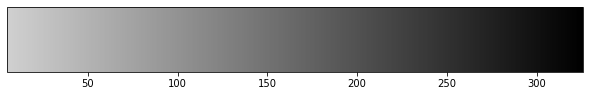

In [ ]:
# Kathrin's entry
# show currently used grayscale
coocc_range = np.array([[lower_threshold, upper_threshold]])

pl.figure(figsize=(10, 1.5))
img = pl.imshow(coocc_range, cmap=graymap)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)

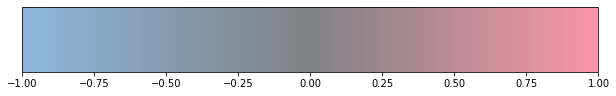

In [ ]:
# Kathrin's entry
# display the currently used colormap (for testing); shows which color is used for which sentiment value [-1, 1]
blue = "#8db6dc" # negative
gray = "#7f8285" # neutral
red = "#f995a6" # positive
colormap = clrs.LinearSegmentedColormap.from_list("", [blue, gray, red], N=201)
color_list = [clrs.rgb2hex(colormap(i)) for i in range(colormap.N)]
sentiment_range = np.array([[-1,1]])

pl.figure(figsize=(10, 1.5))
img = pl.imshow(sentiment_range, cmap=colormap)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)

# Character quotes

In [ ]:
#!pip install allennlp

In [ ]:
#!pip install allennlp allennlp-models
#!pip install cached-path==1.1.2

In [ ]:
# from allennlp.predictors.predictor import Predictor
# predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2021.03.10.tar.gz")

In [ ]:
'''def split_book_to_chapters(book):
    chapters_cv = re.split(r"CHAPTER ((X{0,3})(IX|IV|V?I{0,3}))+\.", book)
    chapters_cv = list(filter(lambda x: (x != ""), chapters_cv))
    chapters_cv = chapters_cv[1:]
    return chapters_cv'''

In [ ]:
# Kathrin's entry
# adapt My's get_quotes function by adding quotationstyle parameter to first find out quotationstyle of book
# function that extracts connected quotation blocks for a singular chapter or the whole book

def extract_conversations(text, quotationstyle):
    quotationstyle = quotationstyle[0] + ".*?" + quotationstyle[1]
    conversations = re.findall(quotationstyle, text)
    return conversations

# find out the book's main quotationstyle
# assumption: the style that appears most frequently is the one used for conversation quotationmarks
# returns the string that can be used as regex for finding quotes
def extract_quotationmark_style(book):
    style1 = [re.findall("\".*?\"", book), ["\"", "\""]]
    style2 = [re.findall("\“.*?\”", book), ["\“", "\”"]] 
    style3 = [re.findall("\«.*?\»", book), ["\«", "\»"]]
    style4 = [re.findall("\„.*?\”", book), ["\„", "\”"]]
    styles = [style1, style2, style3, style4]
    index_max = np.argmax(np.array([len(s[0]) for s in styles]))
    quotation_style_regex = styles[index_max][1]
    return quotation_style_regex

In [ ]:
def get_sentence_speaker(nlpsentence):
    # list from https://www.proofreadingservices.com/pages/said
    say_synonyms = """said accused corrected lamented ridiculed acknowledged coughed laughed roared added countered
    lectured sang admitted cried lied sassed advised croaked lisped scoffed affirmed crowed maintained scolded
    agreed cursed marvelled screamed alleged dared mentioned screeched announced decided mimicked seethed answered
    declared moaned shared apologized defended mocked shot approved demanded motioned shouted argued demurred mumbled
    shrieked asked denied murmured shrilled asserted described mused sighed assured disagreed muttered simpered
    babbled disclosed nagged slurred badgered divulged nodded smirked barked drawled noted snapped bawled dribbled
    objected snarled began echoed observed sneered begged effused offered snickered bellowed emphasized opined sniffed
    bleated encouraged ordered sniffled blubbered exclaimed panted snorted blurted explained pestered sobbed boasted
    exploded piped spat boomed exulted pleaded speculated bragged finished pled spilled breathed fretted pointed
    spluttered bubbled gasped pondered spoke burst gawked praised sputtered cackled gibed prayed squeaked cajoled 
    giggled proclaimed squealed called gloated promised stammered cautioned greeted pronounced started challenged grimaced
    proposed stated chattered groaned protested stormed cheered growled provoked stressed chided grumbled purred stuttered
    chimed grunted suggested chirped guessed puzzled surmised chittered gulped queried taunted choked gurgled
    questioned teased chortled gushed quipped ejaculated tempted chorused hinted quizzed tested chuckled hissed raged testified
    claimed hollered ranted thanked clarified howled reasoned theorized clucked huffed reassured threatened coached hummed 
    recalled thundered coaxed hypothesized reckoned trilled comforted imitated recounted urged commanded implied reiterated 
    volunteered commented implored related vowed complained informed remarked wailed complimented inquired remembered warned 
    conceded insinuated reminded went concluded insisted repeated wept concurred instructed replied wheezed confessed insulted
    reported whimpered confided interjected requested whined confirmed interrupted resounded whispered congratulated
    intimated responded wondered contended jeered retaliated worried continued jested retorted yawned contributed jibed
    returned yelled convinced joked revealed yelped told quoted
    """
    speech_lemmas = "|".join([t.lemma_ for t in nlp(say_synonyms.replace("\n", " ").strip()) if len(t)>2])
    speakkeywords = f"({speech_lemmas})"
    character = ["unknown", -42] # default, overwritten if speaker is found
    
    verb = [w for w in nlpsentence if w.dep_=="ROOT"] 
    
    if verb:
        verb = verb[0]

        # if verb is one related to speaking, search for the person it refers to
        if re.match(speakkeywords, verb.lemma_):

            # two possibilities
                # 1) "...", Anne says --> Anne = nsubj
                # 2) "...", says Anne --> Anne = dobj
                # also: if it says Anne Shirley --> Anne = compound, Shirley = dobj/nsubj 

            charCandidates = []
            for child in verb.children:   # Shirley
                if (child.dep_=="nsubj" or child.dep_=="dobj"):

                    # look for potential compounds; if found, add compounds + dobj/nsubj
                    # all compounds are first added, so that e.g. "Miss Anne Shirley" is found as whole expression
                    # otherwise would find "Miss Anne" and "Anne Shirley" seperately

                    compoundCandidates = [c.text for c in child.children if c.dep_=="compound"]   # [Miss, Anne]
                    compound = compoundCandidates + [child.text]   # [Miss, Anne, Shirley]
                    candidate = nlp(' '.join(compound))   # "Miss Anne Shirley"
                    charCandidates.append((candidate, child.dep_, child.idx))
            
            # if nsubj and dobj can be found, choose nsubj (since subject is usually the speaker)
            if len(charCandidates) > 1:
                nsubjs = [[c[0], c[2]] for c in charCandidates if c[1]=="nsubj"]
                if nsubjs:
                    character = nsubjs[0]
            elif len(charCandidates) == 1:
                character = [charCandidates[0][0], charCandidates[0][2]]
                
    return character[0]

In [ ]:
# takes one coref cluster in the form of a [list of (wordchunk, index) tuples]
def determine_referenced_name(coref_cluster):
    pronouns = ["I", "he", "she", "you", "they", "them", "us", "we", "yourself", "myself", "himself", "me", "him", "them",
                "herself", "ourselves", "yourselves", "themselves", "my", "your", "his", "her", "our", "their"]
    cluster_no_pronouns = [t for t in coref_cluster if t[0] not in pronouns]
    
    # if there are names in the cluster that are not pronouns
    if cluster_no_pronouns:

        # if there is more than one name, ideally choose the longest one that only consists of proper nouns
        # reason: if the full name and first name get mentioned separately, get full name, not just the first name
        if len(cluster_no_pronouns)>1:
            
            c_docs = [nlp(c[0] for c in cluster_no_pronouns)]
            
            proper_nouns = [[c.text for c in c_doc if all([c.pos_=="PROPN" for c in c_doc])] for c_doc in c_docs]
            not_all_propernouns = [[c.text for c in c_doc if not all([c.pos_=="PROPN" for c in c_doc])] for c_doc in c_docs]

            if proper_nouns:
                referenced_name = ' '.join(max(proper_nouns, key=lambda name: len(name)))
                
            # if there is no chunk only consisting of proper nouns, try to strip non-propernoun components of each chunk
            # e.g. would strip the "'s'" in "Diana Barry 's" to only leave and add "Diana Barry" as the final name
            # take longest of these or take the first one, if none exists
            elif not_all_propernouns:
                stripped_to_propn = [[c.text for c in c_doc if c.pos_=="PROPN"] for c_doc in not_all_propernouns]
                if stripped_to_propn:
                    referenced_name = ' '.join(max(stripped_to_propn, key=lambda name: len(name)))
                else: 
                    referenced_name = ' '.join(not_all_propernouns[0])
        
        # if there's only one non-pronoun name, try to strip non-propernoun parts and then assign it as the referenced name
        else:
            c_pos_cleaned = [t.text for t in nlp(cluster_no_pronouns[0][0]) if t.pos_=="PROPN"]
            if c_pos_cleaned:
                referenced_name = ' '.join(c_pos_cleaned)
            else:
                cluster_no_pronouns[0][0]
                
    # if there are only pronouns, take the first pronoun           
    else:
        referenced_name = coref_cluster[0][0]
        
    return referenced_name

In [ ]:
def get_coref_clusters(string_text): 
    # optional paramter for startindex in book, so that you can get absolute index instead of relative index
    
    pred = predictor.predict(string_text)
    clusters, document = pred["clusters"], pred["document"]
    
    # dictionary of each index with the word/token at this index in the text
    word_dict = {}
    for i, token in enumerate(document):
        word_dict[i] = token 
    
    # iterate over list of clusters
    # each cluster consists of list of [startindex, endindex] chunks
    # use these to get the corresponding word from the word_dict + save their index
    # result: each cluster as a [list of (word, index) tuples] belonging to it
    coref_clusters = []
    for cluster in clusters: 
        cluster_tuples = []
        for chunk in cluster:
            start, end = chunk[0], chunk[1]
            
            # a chunk can be more than only one word, so add tokens that belong together first
            full_reference = []
            for token_i in range(start, end+1): 
                full_reference.append(word_dict[token_i])
                
            cluster_tuples.append((' '.join(full_reference), list(range(start, end+1))))
            
        coref_clusters.append(cluster_tuples)
    
    coref_dict = {}
    for cluster in coref_clusters:
        referenced_name = determine_referenced_name(cluster)
        indices = [c[1] for c in cluster]
        coref_dict[referenced_name] = [i for idcs in indices for i in idcs]
        
    return coref_dict

In [ ]:
def resolve_name_at_idx(idx, string_text):
    name = "unknown"
    coref_dict = get_coref_clusters(string_text)
    for k, v in coref_dict.items():
        if idx in v:
            name = k
    return name

In [ ]:
def extract_speakers(txt, quotationstyle):
    
    s = quotationstyle[0]
    e = quotationstyle[1]
    quotationstyle = s + ".*?" + e

    quotes_and_speakers = []

    for quote in re.finditer(quotationstyle, txt):

        startquote_index = quote.start()
        endquote_index = quote.end()
        quoteblock = quote.group()[1:-1]
        character = "unknown"
        
        max_index = min([endquote_index+250, len(txt)])
        min_index = max([startquote_index-250, 0])
        finding_place = False
        sentence_before = False
        sentence_after = False
        
        # first look at sentence after quote, since most of the time, the syntax is: "...," said someone
        if re.search("(\,|\.|\!|\?)", txt[endquote_index-2:endquote_index+2]):

            after_quote = txt[endquote_index:max_index]
            after_quote = re.split(s, after_quote)[0]
                
            doc = nlp(after_quote)
            sentences_after = [sentence for sentence in doc.sents]
            
            if sentences_after:
                sentence_after = sentences_after[0]
                character = str(get_sentence_speaker(sentence_after))
                finding_place = "after"
                
        # if no character was found after, look at sentence before    
        if character=="unknown": 
            before_quote = txt[min_index:startquote_index]
            before_quote = re.split(e, before_quote)[-1]

            doc = nlp(before_quote)
            sentences_before = [sentence for sentence in doc.sents]

            if sentences_before:
                sentence_before = sentences_before[-1]
                character = str(get_sentence_speaker(sentence_before))
                finding_place = "before"
                
        # do coreference analysis if found speaker is a pronoun
        pronouns = ["i", "he", "she", "you", "they", "them", "us", "we", "yourself", "myself", "himself", "me", "him", "them",
                    "herself", "ourselves", "yourselves", "themselves", "my", "your", "his", "her", "our", "their"]
        '''if str(character[0]).lower() in pronouns:
            
            # get whole text block of quote and surrounding context
            contxt = txt[min_index:max_index+1]
            
            if finding_place=="after":
                speaker_sent = str(sentence_after)
            elif finding_place=="before":
                speaker_sent = str(sentence_before)
                
            speaker_sent_startidx = contxt.find(speaker_sent)
            
            coref_search = contxt[:speaker_sent_startidx+len(speaker_sent)+1]
            coref_doc = nlp(coref_search)
            
            pronoun_char_idx = speaker_sent_startidx + character[1]
            pronoun_token_idx = [t.i for t in coref_doc if t.idx==pronoun_char_idx][0]

            try:
                character = resolve_name_at_idx(pronoun_token_idx, coref_search)
            except:
                character = character[0]
                
        else:'''
        
        '''if character=="unknown": 
            if sentence_before:
                subj = [t.text for t in sentence_before if t.dep_=="nsubj"]
                if subj:
                    character = subj[0]
                    
        if character=="unknown": 
            if sentence_after:
                subj = [t.text for t in sentence_after if t.dep_=="nsubj"]
                if subj:
                    character = subj[0]
                    
        if character.lower() in pronouns:
            if sentence_before:
                subj = [t.text for t in sentence_before if t.dep_=="nsubj"]
                if subj:
                    character = subj[0]
                    if character.lower() in pronouns:
                        if len(sentences_before)>1:
                            sec_sentence_before = sentences_before[-2]
                            subj = [t.text for t in sec_sentence_before if t.dep_=="nsubj"]
                            if subj:
                                character = subj[0]'''
        
        quotes_and_speakers.append([quoteblock, character])

    return quotes_and_speakers

In [ ]:
def speakers_per_chapter(cleanedbook, cleanedchapters):
    #chapterlist = split_book_to_chapters(cleanedbook)
    quotationmarks = extract_quotationmark_style(cleanedbook)
    quotes_per_chapter = [extract_speakers(c, quotationmarks) for i, c in enumerate(cleanedchapters)]
    quotes_speaker_dict = {i+1:c for i, c in enumerate(quotes_per_chapter)}
    return quotes_speaker_dict

conversations = speakers_per_chapter(book, list(chapterdict.values()))
conversations

{1: [['ran', 'unknown'],
  ['cotton warp', 'unknown'],
  ['Rachel Lynde’s husband', 'unknown'],
  ['I’ll just step over to Green Gables after tea and find out from Marilla where he’s gone and why,',
   'woman'],
  ['He doesn’t generally go to town this time of year and he never visits; if he’d run out of turnip seed he wouldn’t dress up and take the buggy to go for more; he wasn’t driving fast enough to be going for a doctor. Yet something must have happened since last night to start him off. I’m clean puzzled, that’s what, and I won’t know a minute’s peace of mind or conscience until I know what has taken Matthew Cuthbert out of Avonlea today.',
   'woman'],
  ['It’s just staying, that’s what,', 'she'],
  ['It’s no wonder Matthew and Marilla are both a little odd, living away back here by themselves. Trees aren’t much company, though dear knows if they were there’d be enough of them. I’d ruther look at people. To be sure, they seem contented enough; but then, I suppose, they’re used t

In [ ]:
pronouns = ["i", "he", "she", "you", "they", "them", "us", "we", "yourself", "myself", "himself", "me", "him", "them",
            "herself", "ourselves", "yourselves", "themselves", "my", "your", "his", "her", "our", "their"]
character_quotes = {}
for chapter_nr, qlist in conversations.items():
    for q in qlist:
        quote = q[0]
        speaker = str(q[1])
        if (speaker!="unknown" and speaker.lower() not in pronouns):
            if speaker not in character_quotes:
                character_quotes[speaker] = {c: [] for c in list(conversations.keys())}
            character_quotes[speaker][chapter_nr].append(quote)

In [ ]:
character_quote_dict = {}
for character, chdict in character_quotes.items():
    #character_quote_dict[character] = {c: '' for c in list(chapterdict.keys())}
    character_quotes_as_str = ''
    for c, c_quotes in chdict.items():
        chapterquotes_as_str = '  '.join(c_quotes) # chapter quotes as one string
        #character_quote_dict[character][c] += chapterquotes_as_str
        character_quotes_as_str += chapterquotes_as_str
    
    character_quote_dict[character] = character_quotes_as_str

In [ ]:
quote_dict = {c: '' for c in maincharLookup}
for character, string in character_quote_dict.items():
    for fullname, variations in maincharLookup.items():
        if character in [str(v) for v in variations]:
            quote_dict[fullname] += " "+string
quote_dict

{'Anne Shirley': ' Oh, I’m not ashamed of it,  only I like Cordelia better. I’ve always imagined that my name was Cordelia—at least, I always have of late years. When I was young I used to imagine it was Geraldine, but I like Cordelia better now. But if you call me Anne please call me Anne spelled with an E.  I can’t. I’m in the depths of despair. Can you eat when you are in the depths of despair?  Yes, I have two. The matron of the asylum made them for me. They’re fearfully skimpy. There is never enough to go around in an asylum, so things are always skimpy—at least in a poor asylum like ours. I hate skimpy night-dresses. But one can dream just as well in them as in lovely trailing ones, with frills around the neck, that’s one consolation.I think he’s lovely,  He is so very sympathetic. He didn’t mind how much I talked—he seemed to like it. I felt that he was a kindred spirit as soon as ever I saw him.  I don’t dare go out,  If I can’t stay here there is no use in my loving Green Gabl

In [ ]:
'''import pickle
with open('quotedict.pickle', 'wb') as f:
    pickle.dump(quote_dict, f)
with open('quotedict.pickle', 'rb') as f:
    loaded_obj = pickle.load(f)
loaded_obj'''

# General info

In [ ]:
# get readability score
def score_readability(bookstr):
    # in code of textstat, 5-13 are the possible values
    r_scores = [[i, i+1] for i in [5, 6, 7, 8, 9, 10, 11, 12]]
    r_scores = {i+1: score for i, score in enumerate(r_scores)}
    max_score = len(r_scores)
    
    types = [len(tk) for tk in list(set(bookstr.split()))]
    avg_w_len = statistics.mean(types)
    
    textual_readability = textstat.text_standard(bookstr, float_output=False)
    readability_score = [int(s) for s in re.findall("\d", textual_readability)]
    
    for level, score in r_scores.items():
        if score==readability_score:
            readability_score = level
    
    '''if avg_w_len > 7.0:
        max_i = min(readability_score+2, max_score)
        readability_score = max_i
        textual_readability = re.sub("\dth and", f"{r_scores[readability_score][0]}th and", textual_readability)
        textual_readability = re.sub("\dth grade", f"{r_scores[readability_score][1]}th grade", textual_readability)
        
    elif avg_w_len > 6.0:
        max_i = min(readability_score+1, max_score)
        readability_score = max_i
        textual_readability = re.sub("\dth and", f"{r_scores[readability_score][0]}th and", textual_readability)
        textual_readability = re.sub("\dth grade", f"{r_scores[readability_score][1]}th grade", textual_readability)'''
    
    r_score_dict = {"readability_score": readability_score, "rest_score": max_score-readability_score, "description": f"Suitable for {textual_readability}"}
            
    return r_score_dict

readability_score = score_readability(book)
#createJSON(readability_score, "readability_score", "Crime and Punishment")
readability_score

{'description': 'Suitable for 6th and 7th grade',
 'readability_score': 2,
 'rest_score': 6}

In [ ]:
# get ratio of sentences with quotes in them
def score_quotationratio(bookstr, bookdoc):
    quotes = extract_conversations(bookstr, extract_quotationmark_style(bookstr))
    total_sents = len(list(bookdoc.sents))
    q_sent_count = 0
    for q in quotes:
        qdoc = nlp(q)
        q_sent_count += len(list(qdoc.sents))
    q_ratio = round((q_sent_count/total_sents)*100)
    q_ratio_dict = {"quoation_ratio": q_ratio, "rest_ratio": 100-q_ratio}
    return q_ratio_dict

quotation_ratio = score_quotationratio(book, doc)
#createJSON(quotation_ratio, "quotation_score", "Crime and Punishment")
quotation_ratio

{'quoation_ratio': 77, 'rest_ratio': 23}

In [ ]:
# get estimated reading time
def score_readingtime(bookdoc):
    nr_words = len([t for t in bookdoc if not t.is_punct])
    avg_speed_per_m = 200
    
    time = int(nr_words/avg_speed_per_m)
    hours = int(time/60)
    minutes = time - 60*hours
    
    round_minutes = list(range(0, 61, 5))
    if minutes not in round_minutes:
        for i, rounded in enumerate(round_minutes):
            if (minutes>rounded and minutes<round_minutes[i+1]):
                minutes=rounded
                
    if len(str(minutes))==1:
        reading_time = f"{hours} hours 0{minutes} minutes"
    else:
        reading_time = f"{hours} hours {minutes} minutes"
            
    return reading_time

readingtime_dict = {"Estimated reading time": score_readingtime(doc)}
readingtime_dict

{'Estimated reading time': '8 hours 50 minutes'}

In [ ]:
# get top 3 locations/settings

def is_real_location(locname):
    geo = geocoder.geonames(locname, key='keichhorn')
    if "[ERROR - No results found]" in str(geo):
        return False
    else:
        return True 
    
abs_locations = [t.text for t in doc.ents if ((t.label_=="GPE" or t.label_=="LOC") and t.text not in str(list(fullnameLookup.values())) and not "this" in t.text.lower())]
locations = sorted(list(set(abs_locations)), key=lambda x: abs_locations.count(x), reverse=True)
locations = [l for l in locations if not any(True for w in ["south", "north", "east", "west"] if l.lower()==w)]
loc_freq = {l: abs_locations.count(l) for l in locations}

for i, q in enumerate(loc_freq.copy()):
    for j, l in enumerate(loc_freq.copy()):
        if (loc_freq[q]!=0 and loc_freq[l]!=0 and j>i):
            query = q.lower().replace("city", "").replace("of", "").replace("the", "").strip()
            to_compare = l.lower().replace("city", "").replace("of", "").replace("the", "").strip()
            
            lex_similarity = jellyfish.jaro_distance(query, to_compare)

            if lex_similarity > 0.8:
                loc_freq[q] += loc_freq[l]
                loc_freq[l] = 0
                
top_locations = {k: v for k, v in loc_freq.items() if v > 0}
top_locations = {k: v for k, v in sorted(top_locations.items(), key=lambda x: book.count(x[0].replace("the", "").replace("of", "").replace("city", "").replace("City", "").strip()), reverse=True)}#[:3]
for k in top_locations.copy():
    if (any([True for t in nlp(k.lower()) if t.tag_=="NNS"]) and len(nlp(k))==1):
        top_locations.pop(k)
top_locations = list(top_locations.keys())

topthree_locations = []
i = 0
for l in top_locations:
    if is_real_location(l):
        topthree_locations.append(l)
        i += 1
        if i==3:
            break
toplocations_dict = {"Main Settings": re.sub("(\'|\[|\])", "", str(topthree_locations))}
toplocations_dict

{'Main Settings': 'White Sands, Island, pearl'}

In [ ]:
# average length of sentence (in words)
sent_lens = []
for sent in doc.sents:
    sent_lens.append(len([s for s in sent if not s.is_punct]))
avg_sen_len = round(statistics.mean(sent_lens))
avg_sen_len_dict = {"Sentence length (avg.)": f"{avg_sen_len} words"}
avg_sen_len_dict

{'Sentence length (avg.)': '16 words'}

In [ ]:
# total number of words in book
doc_len = len([t for t in doc if not t.is_punct])
doc_len_dict = {"Total number of words": doc_len}
doc_len_dict

{'Total number of words': 106534}

In [ ]:
# average amount of pages per chapter
ch_page_lens = []
for chnr, chdoc in chapterdocdict.items():
    nr_words = len([t.text for t in chdoc if not t.is_punct])
    nr_pages = ceil(nr_words/300)
    ch_page_lens.append(nr_pages)
avg_pages_per_ch = round(statistics.mean(ch_page_lens))
pages_chapter_dict = {"Chapter length (avg.)": f"{avg_pages_per_ch} pages"}
pages_chapter_dict

{'Chapter length (avg.)': '10 pages'}

In [ ]:
# total number of pages
total_pages_per_book = sum(ch_page_lens)
pages_book_dict = {"Pages": total_pages_per_book}
pages_book_dict

{'Pages': 374}

In [ ]:
general_info = [readingtime_dict, pages_book_dict, doc_len_dict, pages_chapter_dict, avg_sen_len_dict, toplocations_dict]
#createJSON(general_info, "textinfo", "Crime And Punishment")
general_info

[{'Estimated reading time': '8 hours 50 minutes'},
 {'Pages': 374},
 {'Total number of words': 106534},
 {'Chapter length (avg.)': '10 pages'},
 {'Sentence length (avg.)': '16 words'},
 {'Main Settings': 'White Sands, Island, pearl'}]

# Topic Modelling

In [ ]:
# My's entry - Get quotes by sentence (More general way to extract conversations)
sentences = list(doc.sents)

def get_quotes(text):
    quotes = re.findall(r"“(.*?)”", text)
    return quotes

# ISSUE: Words that are wrapped by quotation marks but are not quotes also got included. 

In [ ]:
# My's entry - Extract conversations (ISSUE: Only applicable to this book)

# Suddenly not working anymore
#file_path = "http://www.gutenberg.org/cache/epub/45/pg45.txt"
#with open(file_path, 'r', encoding='utf-8') as rf:
#    book_cv = rf.read()

url = "http://www.gutenberg.org/cache/epub/45/pg45.txt"
response = request.urlopen(url)
book_cv = response.read().decode('utf-8').replace("\r", "")

book_cv = book_cv[book_cv.find("CHAPTER I. Mrs. Rachel Lynde is Surprised") : book_cv.find("*** END OF THE PROJECT GUTENBERG EBOOK")].strip()

chapters_cv = re.split(r"CHAPTER ((X{0,3})(IX|IV|V?I{0,3}))+\.", book_cv)
chapters_cv = list(filter(lambda x: (x != ""), chapters_cv))
conversations = re.split('\n\n', chapters_cv[10])
conversations = list(filter(lambda x: x.startswith('“'), conversations))
#conversations[15]

In [ ]:
# My's entry
# Adding EntityRuler
def create_patterns(doc, ent_label):
    data = get_character_mentions(doc)
    patterns = []
    for item in data:
        pattern = {"label": ent_label, "pattern": item}
        patterns.append(pattern)
    return patterns

patterns = create_patterns(doc, "PERSON")

# Test Spacy's instructions for creating entity ruler  
ruler = nlp.add_pipe("entity_ruler")
ruler.add_patterns(patterns)
#nlp.to_disk("book_entity_ruler")
doc_test = nlp(chapters[0])
for ent in doc_test.ents:
        print (ent.text, ent.label_)

ValueError: ignored

In [ ]:
# My's entry 
# Split UNPROCESSED text into conversations

#with open(file_path, 'r', encoding='utf8') as rf:
#    book_cv = rf.read()
#    book_cv = book_cv[book_cv.find("*** START OF THE PROJECT GUTENBERG EBOOK"):book_cv.find("*** END OF THE PROJECT GUTENBERG EBOOK")].strip()

url = "http://www.gutenberg.org/cache/epub/45/pg45.txt"
response = request.urlopen(url)
book_cv = response.read().decode('utf-8').replace("\r", "")

book_cv = book_cv[book_cv.find("CHAPTER I. Mrs. Rachel Lynde is Surprised") : book_cv.find("*** END OF THE PROJECT GUTENBERG EBOOK")].strip()

def split_book_to_chapters(book):
    chapters_cv = re.split(r"CHAPTER ((X{0,3})(IX|IV|V?I{0,3}))+\.", book)
    chapters_cv = list(filter(lambda x: (x != ""), chapters_cv))
    chapters_cv = chapters_cv[1:]
    return chapters_cv

def get_conversations(text): # text can be a chapter or an entire book
    conversations = re.split('\n\n', text)
    conversations = list(filter(lambda x: x.startswith('“'), conversations))
    return conversations


In [ ]:
# My's entry 
# Find all character mentions by chapter/conversation etc. (improved NER via get_character_mentions())
chapter_dict = {}
for i, chapter in enumerate(chapters_cv):
    chapter_dict[i+1] = [chapter] #brackets around "chapter" are needed, otherwise the dictionary has no index and converting it to a DataFrame will throw ValueError "if using all scalar values, you must pass an index"  

def get_ents_by_chapter_dict(book):
    chapters = split_book_to_chapters(book)
    ents_by_chapter_dict = {}
    for i, chapter in enumerate(chapters):
        chapter_num = i + 1
        person_ents = []
        chapter = chapter.replace("\n\n", " ").replace("\n", " ").strip()
        doc = nlp(chapter)
        for ent in get_character_mentions(doc):
            if ent in chapter:
                person_ents.append(ent)
        ents_by_chapter_dict[chapter_num] = person_ents

    return ents_by_chapter_dict

def get_ents_by_convo_dict(text): # text can be a chapter or an entire book
    ents_by_convo_dict = {}
    conversations = get_conversations(text)
    convo_num = 0 # temporary keys - needs more meaningful keys
    for cv in conversations:
        convo_num += 1 
        person_ents = []
        cv = cv.replace("\n\n", " ").replace("\n", " ").strip()
        doc = nlp(cv)
        for ent in get_character_mentions(doc):
            if ent in cv:
                person_ents.append(ent)
        ents_by_convo_dict[convo_num] = person_ents

    return ents_by_convo_dict

get_ents_by_convo_dict(chapters[1])

{}

## Prepare and clean dataframes and document-term matrix

In [ ]:
# My's entry
pd.set_option("max_colwidth", 150)

chapters_df = pd.DataFrame(chapter_dict).transpose()
chapters_df.columns = ['text']
chapters_df

,text
1,"Mrs. Rachel Lynde is Surprised\n\n\nMRS. Rachel Lynde lived just where the Avonlea main road dipped down\ninto a little hollow, fringed with alde..."
2,Matthew Cuthbert is surprised\n\n\nMATTHEW Cuthbert and the sorrel mare jogged comfortably over the eight\nmiles to Bright River. It was a pretty...
3,Marilla Cuthbert is Surprised\n\n\nMARILLA came briskly forward as Matthew opened the door. But when her\neyes fell on the odd little figure in t...
4,"Morning at Green Gables\n\n\nIT was broad daylight when Anne awoke and sat up in bed, staring\nconfusedly at the window through which a flood of ..."
5,"Anne’s History\n\n\nDO you know,” said Anne confidentially, “I’ve made up my mind to enjoy\nthis drive. It’s been my experience that you can near..."
6,"Marilla Makes Up Her Mind\n\n\nGET there they did, however, in due season. Mrs. Spencer lived in a big\nyellow house at White Sands Cove, and she..."
7,"Anne Says Her Prayers\n\n\nWHEN Marilla took Anne up to bed that night she said stiffly:\n\n“Now, Anne, I noticed last night that you threw your ..."
8,"Anne’s Bringing-up Is Begun\n\n\nFOR reasons best known to herself, Marilla did not tell Anne that\nshe was to stay at Green Gables until the nex..."
9,"Mrs. Rachel Lynde Is Properly Horrified\n\n\nANNE had been a fortnight at Green Gables before Mrs. Lynde arrived to\ninspect her. Mrs. Rachel, to..."
10,Anne’s Apology\n\n\nMARILLA said nothing to Matthew about the affair that evening; but when\nAnne proved still refractory the next morning an exp...


In [ ]:
# My's entry
# Clean chapter text

def lemmatize(text, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"]) # disable redundant packages to reduce running time
    doc = nlp(text)
    lemmatized_text = []
    for token in doc:
        if token.pos_ in allowed_postags and len(token) >= 2: #incorporate len(token) >= 2 to remove words of less than 2 letters
            lemmatized_text.append(token.lemma_)
    lemmatized_text = " ".join(lemmatized_text)
    return lemmatized_text

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\w*\d\w*', '', text) # remove numeric values
    text = re.sub('(\n)+', ' ', text)
    text = lemmatize(text)
    return text

cleaned_chapters_df = pd.DataFrame(chapters_df.text.apply(lambda x: clean_text(x)))

In [ ]:
cleaned_chapters_df

,text
1,surprised live just where avonlea main road dip little hollow fringed alder lady eardrop traverse brook source away back wood old place repute int...
2,surprised jog comfortably mile bright river pretty road run along snug farmstead now again bit balsamy fir wood drive through hollow where wild pl...
3,surprised marilla come briskly forward open door when eye fall odd little figure stiff ugly dress long braid red hair eager luminous eye stop shor...
4,morning green gable broad daylight when awake sit bed stare confusedly window flood cheery sunshine pour white feathery wave glimpse blue sky mome...
5,anne history know say have make mind enjoy drive experience can nearly always enjoy thing make mind firmly will of course must make firmly go thin...
6,make mind there however due season live big yellow house white sand come door surprise welcome mingled benevolent face dear dear exclaim be last f...
7,say prayer when take bed night say now notice last night throw clothe all floor when take very untidy habit can allow at all as soon take article ...
8,begin reason best know tell stay green gable next afternoon forenoon keep child busy various task watch keen eye noon conclude smart obedient will...
9,properly horrify fortnight green gable arrive inspect justice blame severe unseasonable attack confine good lady house ever occasion last visit gr...
10,marilla say affair evening when prove still refractory next morning explanation make account absence breakfast table tell whole story take pain im...


In [ ]:
# My's entry
# Pickle df for later
import pickle
chapters_df.to_pickle("corpus.pkl")

In [ ]:
# My's entry
# create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(cleaned_chapters_df.text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = cleaned_chapters_df.index

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# My's entry
data_dtm.to_pickle("dtm.pkl")
cleaned_chapters_df.to_pickle('cleaned_chapters_df.pkl')
pickle.dump(cv, open("cv.pkl", "wb"))

## Most common words e.g. by chapter --> Word Clouds

In [ ]:
# My's entry
data = pd.read_pickle('dtm.pkl')
data = data.transpose()
data.head()

,1,2,3,4,5,6,7,8,9,10,...,29,30,31,32,33,34,35,36,37,38
abandonment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abasement,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
abash,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
abated,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
abet,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# My's entry
# Find preliminary top 30 words in each chapter
top_words_dict = {}
for chapter_num in data.columns:
    top = data[chapter_num].sort_values(ascending=False).head(30)
    top_words_dict[chapter_num] = list(zip(top.index, top.values))

top_words_dict

{1: [('say', 17),
  ('know', 12),
  ('boy', 11),
  ('marilla', 10),
  ('little', 10),
  ('green', 10),
  ('child', 8),
  ('orphan', 8),
  ('gable', 8),
  ('asylum', 7),
  ('house', 7),
  ('avonlea', 7),
  ('sit', 7),
  ('think', 7),
  ('good', 7),
  ('come', 6),
  ('road', 6),
  ('home', 6),
  ('hollow', 6),
  ('matthew', 6),
  ('people', 5),
  ('thing', 5),
  ('make', 5),
  ('set', 5),
  ('away', 5),
  ('man', 5),
  ('live', 5),
  ('look', 5),
  ('girl', 5),
  ('run', 5)],
 2: [('say', 40),
  ('little', 21),
  ('imagine', 20),
  ('just', 19),
  ('come', 19),
  ('look', 18),
  ('thing', 17),
  ('think', 17),
  ('girl', 15),
  ('know', 14),
  ('long', 14),
  ('feel', 14),
  ('eye', 13),
  ('white', 13),
  ('make', 12),
  ('pretty', 12),
  ('red', 11),
  ('drive', 11),
  ('home', 10),
  ('road', 10),
  ('green', 10),
  ('place', 10),
  ('people', 9),
  ('matthew', 9),
  ('talk', 9),
  ('away', 9),
  ('glad', 9),
  ('ask', 9),
  ('good', 8),
  ('tree', 8)],
 3: [('say', 23),
  ('marilla',

In [ ]:
# My's entry
# Find and add most common top words in the particular text to the built-in stop word list
from collections import Counter

# First find top 30 words for all chapters (top words for each chapter will be investigated later)
words = []
for chapter_num in data.columns:
    top_words = [word for (word, count) in top_words_dict[chapter_num]]
    for w in top_words:
        words.append(w)
        
# Aggregate the top words list above and identify the most common words along with how many chapters they occur in
Counter(words).most_common()

[('say', 38),
 ('think', 38),
 ('know', 35),
 ('just', 35),
 ('marilla', 32),
 ('come', 32),
 ('make', 32),
 ('look', 30),
 ('little', 29),
 ('thing', 29),
 ('good', 28),
 ('time', 26),
 ('girl', 25),
 ('tell', 25),
 ('feel', 22),
 ('home', 13),
 ('eye', 13),
 ('want', 13),
 ('child', 12),
 ('ill', 11),
 ('green', 10),
 ('gable', 9),
 ('away', 9),
 ('imagine', 9),
 ('hand', 9),
 ('sit', 8),
 ('people', 8),
 ('talk', 8),
 ('face', 8),
 ('old', 8),
 ('night', 8),
 ('way', 8),
 ('hair', 8),
 ('right', 8),
 ('anne', 8),
 ('gilbert', 8),
 ('day', 8),
 ('ask', 7),
 ('really', 7),
 ('room', 7),
 ('school', 7),
 ('heart', 7),
 ('matthew', 6),
 ('long', 6),
 ('mean', 6),
 ('boy', 5),
 ('road', 5),
 ('pretty', 5),
 ('glad', 5),
 ('bring', 5),
 ('love', 5),
 ('year', 5),
 ('read', 5),
 ('stay', 5),
 ('friend', 5),
 ('like', 5),
 ('evening', 5),
 ('head', 5),
 ('write', 5),
 ('life', 5),
 ('white', 4),
 ('bed', 4),
 ('word', 4),
 ('lovely', 4),
 ('suppose', 4),
 ('let', 4),
 ('try', 4),
 ('class',

In [ ]:
# My's entry
# If around 1/3 of the chapters (= 38/4 ~ 12) have a word as a top word, exclude it from the list
additional_stop_words = [word for word, count in Counter(words).most_common() if count > 12]
additional_stop_words

['say',
 'think',
 'know',
 'just',
 'marilla',
 'come',
 'make',
 'look',
 'little',
 'thing',
 'good',
 'time',
 'girl',
 'tell',
 'feel',
 'home',
 'eye',
 'want']

In [ ]:
# My's entry
# Update document-term matrix with the additional stop words
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

# Read in cleaned data
data_cleaned = pd.read_pickle('cleaned_chapters_df.pkl')

# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words)

# Add to stop words list the stem words of current stop words
stop_words_string = ""
stop_words_lemma = []
for sw in stop_words:
    stop_words_string += sw + " "
    
doc_sw = nlp(stop_words_string)
stop_words_lemma = [word.lemma_ for word in doc_sw]
stop_words = stop_words.union(stop_words_lemma)

# Add contraction words to stop words list
contraction_words = ["isnt", "arent", "aint", "wasnt", "werent", "theres", "therere", "thats", "thatd", "ive", "weve", "theyve", "youre", "were", "theyre", "hes", "shes", "its", "havent", "hasnt", "mightnt", "maynt", "neednt", "mayve", "mightve", "couldve", "didnt", "dont", "wont", "cant", "couldnt", "shouldnt", "oughtnt", "mustnt", "mustve", "shouldve", "shant", "ill", "youll", "theyll", "itll", "id", "youd", "hed", "theyd", "itd", "im", "maam", "hows", "gonna"]
stop_words = stop_words.union(contraction_words)

# Add contraction words to stop words list
other_stop_words = ["thing", "things", "person", "people", "know", "think", "suppose", "let", "make", "like", "really", "just", "quite", "here", "there"]
stop_words = stop_words.union(other_stop_words)

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_cleaned.text)
dtm_new_stopw = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
dtm_new_stopw.index = data_cleaned.index

pickle.dump(cv, open("cv_new_stopw.pkl", "wb"))
dtm_new_stopw.to_pickle("dtm_new_stopw.pkl")

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pron'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
# My's entry
data = dtm_new_stopw.transpose()
for chapter_num in data.columns:
    top = data[chapter_num].sort_values(ascending=False).head(30)
    top_values_native_int = map(lambda x: int(x), top.values) # use the built-in int() (or float) constructor to convert the numpy integer to a native Python integer before serializing it, because json.dumps() method doesn't handle numpy integers by default (or else get TypeError: Object of type int64 is not JSON serializable).
    top_words_dict[chapter_num] = list(zip(top.index, top_values_native_int))

top_words_dict

{1: [('boy', 11),
  ('green', 10),
  ('child', 8),
  ('gable', 8),
  ('orphan', 8),
  ('asylum', 7),
  ('avonlea', 7),
  ('house', 7),
  ('sit', 7),
  ('hollow', 6),
  ('road', 6),
  ('matthew', 6),
  ('bright', 5),
  ('set', 5),
  ('man', 5),
  ('live', 5),
  ('run', 5),
  ('away', 5),
  ('use', 4),
  ('risk', 4),
  ('ask', 4),
  ('place', 4),
  ('lynde', 4),
  ('turn', 4),
  ('course', 4),
  ('step', 4),
  ('brook', 4),
  ('mind', 4),
  ('river', 4),
  ('bring', 4)],
 2: [('imagine', 20),
  ('long', 14),
  ('white', 13),
  ('pretty', 12),
  ('drive', 11),
  ('red', 11),
  ('road', 10),
  ('green', 10),
  ('place', 10),
  ('away', 9),
  ('matthew', 9),
  ('talk', 9),
  ('ask', 9),
  ('glad', 9),
  ('child', 8),
  ('asylum', 8),
  ('use', 8),
  ('big', 8),
  ('tree', 8),
  ('beautiful', 8),
  ('orphan', 7),
  ('gable', 7),
  ('hair', 7),
  ('dream', 7),
  ('expect', 7),
  ('wild', 7),
  ('guess', 6),
  ('right', 6),
  ('end', 6),
  ('leave', 6)],
 3: [('boy', 12),
  ('bed', 11),
  ('ch

In [ ]:
# My's entry
import json
def save_data(file, data):
    with open(file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

save_data("top_words_by_chapter.json", top_words_dict)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ValueError: ignored

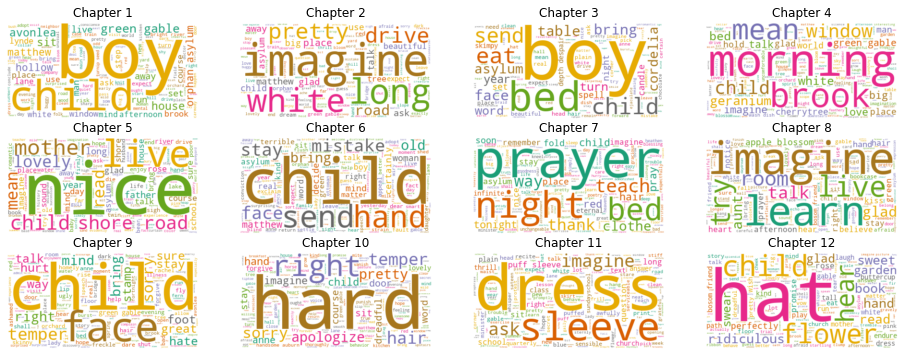

In [ ]:
# My's entry
# Create demo word clouds
!pip install wordcloud
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

# Reset visualization dimensions
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 6]

# Create subplots for each chapter
for chapter_num in data.columns:
    wc.generate(data_cleaned.text[chapter_num])
    
    plt.subplot(3, 4, chapter_num)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Chapter "+ str(chapter_num))
    
plt.show()

## TF-IDF and LDA - Topic Distribution e.g. by chapter

In [ ]:
# My's entry
!pip3 install gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import matutils, models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# My's entry
# Apply LDA only on bigrams and trigrams from the text instead of the entire text
chapters_texts = list(cleaned_chapters_df["text"].values)
chapters_texts_split = [text.split() for text in chapters_texts]

bigram_phrases = gensim.models.Phrases(chapters_texts_split, min_count=2, threshold=50)
trigram_phrases = gensim.models.Phrases(bigram_phrases[chapters_texts_split], threshold=50)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def get_bigrams(texts):
    return([bigram[doc] for doc in texts])

def get_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

chapters_bigrams = get_bigrams(chapters_texts_split)
chapters_bigrams_trigrams = get_trigrams(chapters_bigrams)

def exclude_stop_words(word_list):
    word_list = list(filter(lambda x: x not in stop_words and len(x) >= 2, word_list))
    return word_list

chapters_bigrams_trigrams = [exclude_stop_words(word_list) for word_list in chapters_bigrams_trigrams]

print(chapters_bigrams_trigrams)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


[['surprised', 'live', 'avonlea', 'main_road', 'dip', 'hollow', 'fringed', 'alder', 'lady', 'eardrop', 'traverse', 'brook', 'source', 'away', 'wood', 'old', 'place', 'repute', 'intricate', 'headlong', 'brook', 'early', 'course', 'wood', 'dark', 'secret', 'pool', 'cascade', 'reach', 'lynde_hollow', 'quiet', 'wellconducted', 'stream', 'brook', 'run', 'lynde', 'door', 'regard', 'decency', 'decorum', 'probably', 'conscious', 'sit', 'window', 'sharp', 'pass', 'child', 'notice', 'odd', 'place', 'rest', 'ferret', 'wherefore', 'plenty', 'attend', 'closely', 'neighbor', 'business', 'dint', 'neglect', 'capable', 'creature', 'manage', 'concern', 'folk', 'bargain', 'notable', 'housewife', 'work', 'run', 'sewing', 'circle', 'help', 'run', 'sundayschool', 'strong', 'prop', 'church', 'aid_society', 'foreign', 'mission', 'auxiliary', 'abundant', 'sit', 'hour', 'kitchen', 'window', 'cotton', 'quiltsshe', 'knit', 'avonlea', 'housekeeper', 'sharp', 'main_road', 'cross', 'hollow', 'wind', 'steep', 'red', 

In [ ]:
# My's entry

# Prepare inputs for LDA model
id2word = corpora.Dictionary(chapters_bigrams_trigrams)
texts = chapters_bigrams_trigrams
corpus = [id2word.doc2bow(text) for text in texts] #gensim.corpora.Dictionary.doc2bow(document): Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples

# Use TF-IDF to remove words that are too common to be meaningful 
from gensim.models import TfidfModel
tfidf = TfidfModel(corpus, id2word=id2word)

threshold = 0.03 # arbitrarily chosen tf-idf score as threshold for excluding too common words
zero_tfidf_score_words = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_tfidf_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_tfidf_words = [id for id, value in tfidf[bow] if value < threshold]
    zero_tfidf_score_words = [id for id in bow_ids if id not in tfidf_ids] # exclude words with tf-idf score = 0 

    new_bow = [b for b in bow if b[0] not in low_tfidf_words and b[0] not in zero_tfidf_score_words]
    corpus[i] = new_bow
    
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7,
                                           passes=50,
                                           alpha="auto")

lda_model.print_topics()

# TO-DO: remove single words that are part of a bigram/trigram in the same topic

[(0,
  '0.008*"school" + 0.008*"gilbert" + 0.006*"imagine" + 0.005*"class" + 0.004*"write" + 0.004*"boy" + 0.004*"friend" + 0.003*"room" + 0.003*"road" + 0.003*"glad"'),
 (1,
  '0.007*"nice" + 0.007*"tea" + 0.005*"boy" + 0.005*"mother" + 0.005*"child" + 0.005*"glad" + 0.004*"drive" + 0.004*"asylum" + 0.004*"table" + 0.004*"bed"'),
 (2,
  '0.008*"dress" + 0.006*"school" + 0.004*"concert" + 0.003*"matthew" + 0.003*"gilbert" + 0.003*"bed" + 0.003*"dark" + 0.003*"sorry" + 0.003*"pass" + 0.003*"sleeve"'),
 (3,
  '0.015*"hair" + 0.008*"picnic" + 0.008*"brooch" + 0.005*"wicked" + 0.005*"room" + 0.005*"confess" + 0.004*"punish" + 0.004*"forgive" + 0.004*"dye" + 0.004*"shell"'),
 (4,
  '0.007*"morning" + 0.006*"stacy" + 0.006*"picnic" + 0.006*"read" + 0.005*"write" + 0.005*"school" + 0.004*"study" + 0.004*"story" + 0.003*"brook" + 0.003*"book"'),
 (5,
  '0.009*"minister" + 0.008*"flat" + 0.008*"prayer" + 0.007*"cake" + 0.005*"elaine" + 0.005*"mistake" + 0.005*"new" + 0.005*"minister_wife" + 0.0

In [ ]:
# My's entry
# List of all chapters with its assigned topic(s) and their probabilities
lda_corpus = lda_model[corpus]
list(zip([j for i, j in zip(lda_corpus,cleaned_chapters_df.index)], [i for i, j in zip(lda_corpus,cleaned_chapters_df.index)]))

[(1, [(2, 0.9998327)]),
 (2, [(0, 0.999887)]),
 (3, [(1, 0.99978185)]),
 (4, [(4, 0.9997677)]),
 (5, [(1, 0.99976623)]),
 (6, [(1, 0.99975526)]),
 (7, [(5, 0.99962413)]),
 (8, [(0, 0.9998328)]),
 (9, [(2, 0.9998207)]),
 (10, [(3, 0.99979496)]),
 (11, [(2, 0.9997631)]),
 (12, [(5, 0.99977857)]),
 (13, [(4, 0.9996885)]),
 (14, [(3, 0.9997503)]),
 (15, [(0, 0.99989367)]),
 (16, [(1, 0.9998305)]),
 (17, [(0, 0.999828)]),
 (18, [(0, 0.9998328)]),
 (19, [(2, 0.99985856)]),
 (20, [(2, 0.9997925)]),
 (21, [(5, 0.99982446)]),
 (22, [(1, 0.99968916)]),
 (23, [(6, 0.99975514)]),
 (24, [(0, 0.89252603), (5, 0.10726981)]),
 (25, [(2, 0.9684991), (5, 0.031373814)]),
 (26, [(4, 0.99977094)]),
 (27, [(3, 0.999757)]),
 (28, [(5, 0.9997693)]),
 (29, [(1, 0.9998271)]),
 (30, [(4, 0.9998499)]),
 (31, [(0, 0.9728283), (5, 0.027022267)]),
 (32, [(2, 0.99981314)]),
 (33, [(6, 0.9998434)]),
 (34, [(0, 0.99982506)]),
 (35, [(0, 0.9997968)]),
 (36, [(0, 0.9997758)]),
 (37, [(3, 0.99978465)]),
 (38, [(2, 0.99982

In [ ]:
# My's entry
# Clustering of chapters based on their topics
cluster1 = [j for i,j in zip(lda_corpus,cleaned_chapters_df.index) if i[0][0] == 0] # i[0] is selected so that only the topic with the highest probability - in case a chapter is originally assigned to multiple chapters - is officially assigned to the chapter
cluster2 = [j for i,j in zip(lda_corpus,cleaned_chapters_df.index) if i[0][0] == 1]
cluster3 = [j for i,j in zip(lda_corpus,cleaned_chapters_df.index) if i[0][0] == 2]
cluster4 = [j for i,j in zip(lda_corpus,cleaned_chapters_df.index) if i[0][0] == 3]
cluster5 = [j for i,j in zip(lda_corpus,cleaned_chapters_df.index) if i[0][0] == 4]
cluster6 = [j for i,j in zip(lda_corpus,cleaned_chapters_df.index) if i[0][0] == 5]
cluster7 = [j for i,j in zip(lda_corpus,cleaned_chapters_df.index) if i[0][0] == 6]

print(cluster1)
print(cluster2)
print(cluster3)
print(cluster4)
print(cluster5)
print(cluster6)
print(cluster7)

[2, 8, 15, 17, 18, 24, 31, 34, 35, 36]
[3, 5, 6, 16, 22, 29]
[1, 9, 11, 19, 20, 25, 32, 38]
[10, 14, 27, 37]
[4, 13, 26, 30]
[7, 12, 21, 28]
[23, 33]


In [ ]:
# My's entry
# For comparison - Applying LDA on the entire text
cleaned_chapters_df['text_split'] = cleaned_chapters_df['text'].apply(lambda x: x.split(" ")) 
cleaned_chapters_df['text_split'] = cleaned_chapters_df['text_split'].apply(exclude_stop_words) 
dictionary = corpora.Dictionary(cleaned_chapters_df["text_split"])

doc_term_matrix = [dictionary.doc2bow(doc) for doc in cleaned_chapters_df["text_split"]]

ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix,num_topics=7,id2word=dictionary,passes=50)
ldamodel.print_topics()

[(0,
  '0.006*"green" + 0.006*"hair" + 0.005*"dress" + 0.005*"white" + 0.004*"gable" + 0.004*"talk" + 0.004*"night" + 0.004*"long" + 0.004*"glad" + 0.004*"old"'),
 (1,
  '0.006*"pass" + 0.005*"night" + 0.005*"school" + 0.005*"bed" + 0.004*"anne" + 0.004*"head" + 0.004*"heart" + 0.004*"day" + 0.003*"way" + 0.003*"ask"'),
 (2,
  '0.005*"long" + 0.005*"gilbert" + 0.004*"old" + 0.004*"flat" + 0.004*"course" + 0.004*"anne" + 0.004*"hand" + 0.004*"school" + 0.004*"away" + 0.003*"friend"'),
 (3,
  '0.000*"right" + 0.000*"sit" + 0.000*"child" + 0.000*"green" + 0.000*"ask" + 0.000*"school" + 0.000*"long" + 0.000*"old" + 0.000*"pretty" + 0.000*"way"'),
 (4,
  '0.005*"cake" + 0.005*"gable" + 0.004*"face" + 0.004*"tear" + 0.004*"away" + 0.004*"sit" + 0.004*"green" + 0.004*"love" + 0.004*"child" + 0.004*"minister"'),
 (5,
  '0.006*"school" + 0.006*"imagine" + 0.005*"child" + 0.005*"right" + 0.004*"sit" + 0.004*"talk" + 0.004*"hair" + 0.004*"head" + 0.004*"way" + 0.004*"hear"'),
 (6,
  '0.011*"picni

In [ ]:
# Test: Noun-adj pairs
test = cleaned_chapters_df["text"][1]
doc = nlp(test)
noun_adj_pairs = {}
for chunk in doc.noun_chunks:
    adj = []
    noun = ""
    for tok in chunk:
        if tok.pos_ == "NOUN":
            noun = tok.text
        if tok.pos_ == "ADJ" or tok.pos_ == "CCONJ":
            adj.append(tok.text)
    if noun:
        noun_adj_pairs.update({noun:" ".join(adj)})
noun_adj_pairs